# Комплексное исследование (магазин спортивных товаров)

#### Нам предстоит с помощью данных о покупках клиентов и их социально-демографических признаках проанализировать эффективность уже проведённых маркетинговых кампаний и выявить факторы, способные повысить продажи.


In [1]:
# Исследование состоит из пяти частей: 

# предобработки данных,
# бинарной классификации,
# проведения A/B-тестирования,
# кластеризации,
# построения модели склонности клиента к покупке определенного товара.

# Нам предоставлены данные о покупках клиентов за два месяца.

## Librares

In [2]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.manifold import TSNE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, make_scorer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import silhouette_score

from scipy.stats import chisquare
from scipy import stats


## Data Understanding and Data Preparation

#### Data Cleaning

In [3]:
# база данных

# personal_data — ID клиентов, пол, возраст, образование, страна и город проживания

# personal_data_coeffs — данные с персональными коэффициентами клиентов, которые рассчитываются по некоторой закрытой схеме 
# (нам потребуется коэффициент personal_coef)

# purchases — данные о покупках: ID покупателя, название товара, цвет, стоимость, 
# гендерная принадлежность потенциальных покупателей товара, наличие скидки 
# (поле base_sale. Значение 1 соответствует наличию скидки на момент покупки) и дата покупки

dbfile = 'shop_database.db'
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(f"Table Name: {cursor.fetchall()}")

Table Name: [('purchases',), ('personal_data_coeffs',), ('personal_data',)]


In [4]:
df_personal = pd.read_sql_query("select personal_data_coeffs.id as id, personal_coef, \
                        age, gender, education, city, country from personal_data_coeffs \
                        LEFT join personal_data \
                        on personal_data_coeffs.id=personal_data.id \
                        union \
                        select personal_data_coeffs.id as id, personal_coef, \
                        age, gender, education, city, country from personal_data \
                        LEFT join personal_data_coeffs \
                        on personal_data_coeffs.id=personal_data.id \
                        ", conn)

In [5]:
df_personal

,id,personal_coef,age,gender,education,city,country
0,0,0.5072,36.0,0.0,среднее,1201.0,32.0
1,3,0.4304,NaN,NaN,None,NaN,NaN
2,4,0.5072,35.0,0.0,среднее,1134.0,32.0
3,6,0.4304,52.0,1.0,среднее,1188.0,32.0
4,7,0.5072,37.0,0.0,среднее,1198.0,32.0
...,...,...,...,...,...,...,...
104984,177998,0.5072,32.0,0.0,среднее,1201.0,32.0
104985,177999,0.4304,34.0,1.0,среднее,1163.0,32.0
104986,178001,0.2576,5.0,1.0,среднее,1208.0,32.0
104987,178002,0.4304,NaN,NaN,None,NaN,NaN


In [6]:
# personal_data.csv.gz - ID клиентов, возраст, образование, страна и город проживания
# данный файл с утерянными данными по gender (пол клиента)

df_unknown_gender = pd.read_csv("personal_data.csv.gz", compression='gzip')
df_unknown_gender = df_unknown_gender.sort_values("id").reset_index().drop("index", axis=1)
df_unknown_gender["gender"] = None

In [7]:
df_unknown_gender

,id,age,education,city,country,gender
0,3,31,среднее,1134,32,None
1,33,34,среднее,1167,32,None
2,42,46,среднее,1134,32,None
3,44,36,среднее,1181,32,None
4,53,31,среднее,1188,32,None
...,...,...,...,...,...,...
15743,177942,23,высшее,1134,32,None
15744,177955,24,высшее,1193,32,None
15745,177968,49,высшее,1157,32,None
15746,177984,43,среднее,1204,32,None


In [8]:
# выделяем ту часть, которая заполнена полностью

df_personal_full = df_personal.loc[~df_personal.gender.isna()].reset_index().drop("index", axis=1)

In [9]:
df_personal_full

,id,personal_coef,age,gender,education,city,country
0,0,0.5072,36.0,0.0,среднее,1201.0,32.0
1,4,0.5072,35.0,0.0,среднее,1134.0,32.0
2,6,0.4304,52.0,1.0,среднее,1188.0,32.0
3,7,0.5072,37.0,0.0,среднее,1198.0,32.0
4,9,0.5072,48.0,0.0,среднее,1134.0,32.0
...,...,...,...,...,...,...,...
89236,177997,0.5072,28.0,0.0,среднее,1134.0,32.0
89237,177998,0.5072,32.0,0.0,среднее,1201.0,32.0
89238,177999,0.4304,34.0,1.0,среднее,1163.0,32.0
89239,178001,0.2576,5.0,1.0,среднее,1208.0,32.0


In [10]:
# и ту часть, которая не заполнена по полу клиента

df_personal_not_full = df_personal.loc[df_personal.gender.isna()].reset_index().drop("index", axis=1)
df_personal_not_full = df_personal_not_full.fillna(df_unknown_gender)

In [11]:
df_personal_not_full

,id,personal_coef,age,gender,education,city,country
0,3,0.4304,31,None,среднее,1134,32
1,33,0.4304,34,None,среднее,1167,32
2,42,0.5072,46,None,среднее,1134,32
3,44,0.5072,36,None,среднее,1181,32
4,53,0.4304,31,None,среднее,1188,32
...,...,...,...,...,...,...,...
15743,177942,0.4688,23,None,высшее,1134,32
15744,177955,0.4688,24,None,высшее,1193,32
15745,177968,0.4688,49,None,высшее,1157,32
15746,177984,0.5072,43,None,среднее,1204,32


In [12]:
# объединяем в один DataFrame

df_personal_ = pd.concat([df_personal_full, df_personal_not_full]).reset_index().drop("index", axis=1)

In [13]:
df_personal_

,id,personal_coef,age,gender,education,city,country
0,0,0.5072,36.0,0.0,среднее,1201.0,32.0
1,4,0.5072,35.0,0.0,среднее,1134.0,32.0
2,6,0.4304,52.0,1.0,среднее,1188.0,32.0
3,7,0.5072,37.0,0.0,среднее,1198.0,32.0
4,9,0.5072,48.0,0.0,среднее,1134.0,32.0
...,...,...,...,...,...,...,...
104984,177942,0.4688,23.0,NaN,высшее,1134.0,32.0
104985,177955,0.4688,24.0,NaN,высшее,1193.0,32.0
104986,177968,0.4688,49.0,NaN,высшее,1157.0,32.0
104987,177984,0.5072,43.0,NaN,среднее,1204.0,32.0


In [14]:
df_personal_.shape

(104989, 7)

In [15]:
df_personal_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   personal_coef  104989 non-null  float64
 2   age            104989 non-null  float64
 3   gender         89241 non-null   float64
 4   education      104989 non-null  object 
 5   city           104989 non-null  float64
 6   country        104989 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ MB


In [16]:
# дубликаты не найдены

df_personal_[df_personal_.duplicated()]

,id,personal_coef,age,gender,education,city,country


In [17]:
# количество пустых в gender

df_personal_.isna().sum()

id                   0
personal_coef        0
age                  0
gender           15748
education            0
city                 0
country              0
dtype: int64

In [18]:
# распределение столбца gender, включая незаполненные значения 

df_personal_.gender.value_counts(dropna=False)

gender
1.0    51132
0.0    38109
NaN    15748
Name: count, dtype: int64

In [19]:
# преобразуем столбец education

df_personal_["education"] = df_personal_["education"].astype('category')
df_personal_["education"] = df_personal_.education.cat.rename_categories({'среднее': 0, 'высшее': 1}).astype('int64')

In [20]:
df_personal_

,id,personal_coef,age,gender,education,city,country
0,0,0.5072,36.0,0.0,0,1201.0,32.0
1,4,0.5072,35.0,0.0,0,1134.0,32.0
2,6,0.4304,52.0,1.0,0,1188.0,32.0
3,7,0.5072,37.0,0.0,0,1198.0,32.0
4,9,0.5072,48.0,0.0,0,1134.0,32.0
...,...,...,...,...,...,...,...
104984,177942,0.4688,23.0,NaN,1,1134.0,32.0
104985,177955,0.4688,24.0,NaN,1,1193.0,32.0
104986,177968,0.4688,49.0,NaN,1,1157.0,32.0
104987,177984,0.5072,43.0,NaN,0,1204.0,32.0


In [21]:
# посмотрим на корреляцию признаков

# у признака gender в наличии средняя отрицательная корреляция с personal_coef -0.60
# у признака age в наличии слабая положительная корреляция с personal_coef 0.30

df_cor = df_personal_
df_cor.corr()

,id,personal_coef,age,gender,education,city,country
id,1.000000,-0.000605,0.004208,0.001637,0.001037,0.002279,-0.004262
personal_coef,-0.000605,1.000000,0.301966,-0.607388,-0.117542,0.047160,0.023358
age,0.004208,0.301966,1.000000,-0.109659,-0.570686,-0.004719,0.001393
gender,0.001637,-0.607388,-0.109659,1.000000,0.126725,0.004903,-0.010563
education,0.001037,-0.117542,-0.570686,0.126725,1.000000,-0.007046,-0.002329
city,0.002279,0.047160,-0.004719,0.004903,-0.007046,1.000000,0.042603
country,-0.004262,0.023358,0.001393,-0.010563,-0.002329,0.042603,1.000000


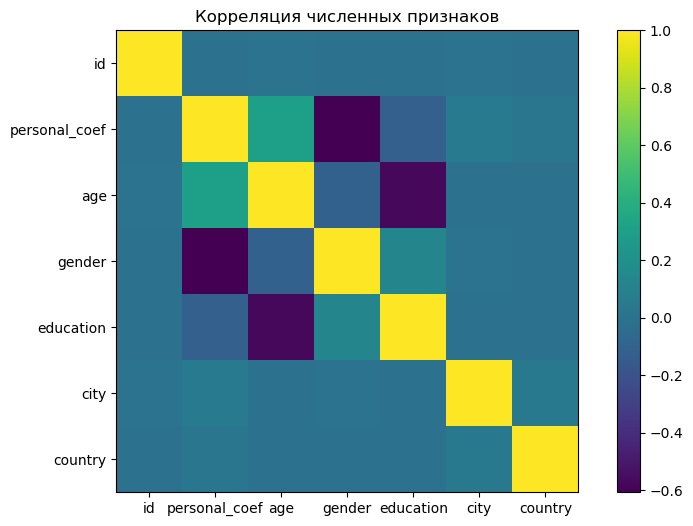

In [22]:
# тепловая карта (heat map) для определения зависимости

plt.figure(figsize=(10, 6))

columns = df_cor.corr().columns.tolist()
plt.imshow(df_cor.corr())

plt.title("Корреляция численных признаков")
plt.xticks(range(0, len(columns)), columns)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show()

In [24]:
# посмотрим на зависимость персонального коэффициента клиента от возраста

def show_age_charges(df):
    plt.plot(df_personal_['personal_coef'], df_personal_.age, 'ro') 
    plt.xlabel('personal_coef')
    plt.ylabel('age')
    plt.title('Зависимость коэффициента от возраста')
    plt.show()

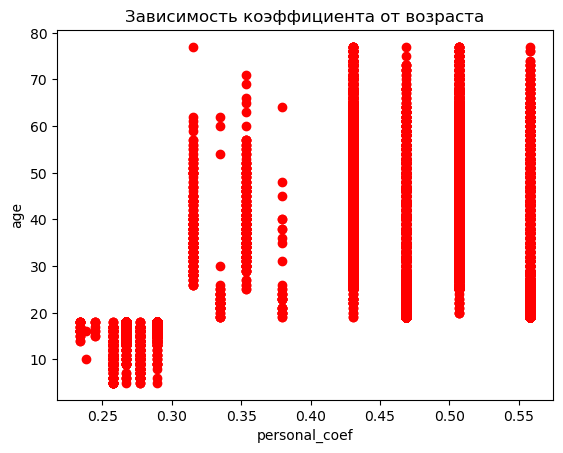

In [25]:
# малые коэффициенты у возраста до 20 лет

show_age_charges(df_personal_)

#### Modelling (binary classification (gender))

In [26]:
# При передаче данных выяснилось, что часть информации о клиентах из таблицы personal_data была утеряна. 
# Поэтому, помимо базы данных, нам предоставили сжатый CSV-файл с утерянными данными (personal_data.csv.gz). 
# Нам необходимо построить модель классификации на полных данных, чтобы, соответственно, восстановить утерянные данные по gender

In [27]:
df_personal_.gender.value_counts(dropna=False)

gender
1.0    51132
0.0    38109
NaN    15748
Name: count, dtype: int64

In [28]:
# будем предсказывать признак gender
# разобъем наш DataFrame на train и test
# в train берем все строки, где у нас этот признак заполнен
# в test попадут все строки, в которых значение этого признака пропущено, пустые значения gender


df_personal_train = df_personal_[~df_personal_.gender.isna()]
df_personal_test = df_personal_[df_personal_.gender.isna()]

In [29]:
df_personal_test.shape

(15748, 7)

In [30]:
# теперь обучим логистическую регрессию на df_personal_train

logreg = LogisticRegression(random_state=42, C=1, penalty='l2', solver='liblinear', max_iter=1000)

In [31]:
# удаляем из обучения на train колонку gender, т.к. ее собственно мы и будем предсказывать, 
# после запятой подаем эту колонку

logreg.fit(df_personal_train.drop("gender", axis=1), df_personal_train.gender)

LogisticRegression(C=1, max_iter=1000, random_state=42, solver='liblinear')

In [32]:
# теперь предскажем наше значение

df_personal_test["gender"] = logreg.predict(df_personal_test.drop("gender", axis=1))

C:\Users\Julia\AppData\Local\Temp\ipykernel_18460\3411271261.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_personal_test["gender"] = logreg.predict(df_personal_test.drop("gender", axis=1))


In [33]:
# проверяем что получилось

df_personal_test

,id,personal_coef,age,gender,education,city,country
89241,3,0.4304,31.0,1.0,0,1134.0,32.0
89242,33,0.4304,34.0,1.0,0,1167.0,32.0
89243,42,0.5072,46.0,1.0,0,1134.0,32.0
89244,44,0.5072,36.0,1.0,0,1181.0,32.0
89245,53,0.4304,31.0,1.0,0,1188.0,32.0
...,...,...,...,...,...,...,...
104984,177942,0.4688,23.0,1.0,1,1134.0,32.0
104985,177955,0.4688,24.0,1.0,1,1193.0,32.0
104986,177968,0.4688,49.0,1.0,1,1157.0,32.0
104987,177984,0.5072,43.0,1.0,0,1204.0,32.0


In [34]:
# видим, что пропуски в gender заполнились

df_personal_test.gender.value_counts(dropna=False)

gender
1.0    14311
0.0     1437
Name: count, dtype: int64

##### cross_validation

In [35]:
# обучим на кросс-валидации 

logreg = LogisticRegression(random_state=42, C=1, penalty='l2', solver='liblinear', max_iter=1000)

In [36]:
# получаем значения метрик на тестовых фолдах, (accuracy)

cv_score_accuracy = cross_val_score(logreg, df_personal_train.drop("gender", axis=1), df_personal_train.gender, cv=5, scoring='accuracy')
cv_score_accuracy

array([0.56597008, 0.56084715, 0.56981174, 0.5707082 , 0.57177275])

In [37]:
# получаем значения метрик на тестовых фолдах, precision (точность)

cv_score_precision = cross_val_score(logreg, df_personal_train.drop("gender", axis=1), df_personal_train.gender, cv=5, scoring='precision')
cv_score_precision

array([0.57903123, 0.57516052, 0.57786334, 0.57638227, 0.57618823])

In [38]:
# получаем значения метрик на тестовых фолдах, recall (полнота)

cv_score_recall = cross_val_score(logreg, df_personal_train.drop("gender", axis=1), df_personal_train.gender, cv=5, scoring='recall')
cv_score_recall

array([0.8883348 , 0.89350675, 0.92460395, 0.94601995, 0.95541214])

In [39]:
# получаем значения метрик на тестовых фолдах f1-score (F1-мера)

cv_score_f1 = cross_val_score(logreg, df_personal_train.drop("gender", axis=1), df_personal_train.gender, cv=5, scoring='f1')
cv_score_f1

array([0.70108423, 0.6998315 , 0.71122311, 0.71632729, 0.71885231])

In [40]:
# смотрим на среднее значение и отклонение, 
# отклонение получилось небольшим, значит метрика не скачет от итерации к итерации и не переобучается

In [41]:
# среднее и std по accuracy

cv_score_accuracy.mean(), cv_score_accuracy.std()

(0.5678219859919055, 0.003999393237127669)

In [42]:
# среднее и std по f1-мера

cv_score_f1.mean(), cv_score_f1.std()

(0.7094636856287146, 0.007763313456323717)

In [43]:
# оставим средний результат по F1-мера 0.70

##### train_test_split

In [44]:
# у нас есть DataFrame df_personal_train с признаками и заполненной колонкой "gender"
# разделение данных на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(df_personal_train.drop("gender", axis=1), df_personal_train.gender, test_size=0.2, random_state=42)

# обучение модели
logreg = LogisticRegression(random_state=42, C=1, penalty='l2', solver='liblinear', max_iter=1000)
logreg.fit(X_train, y_train)

# кросс-валидация
cv_score_f1 = cross_val_score(logreg, X_train, y_train, cv=5, scoring='f1')

# метрика на обучающем наборе данных
train_predictions = logreg.predict(X_train)
train_f1 = f1_score(y_train, train_predictions)

# метрика на тестовом наборе данных
test_predictions = logreg.predict(X_test)
test_f1 = f1_score(y_test, test_predictions)

print(f"F1 на обучающем наборе данных: {train_f1}")
print(f"F1 на тестовом наборе данных: {test_f1}")
print(f"F1 на кросс-валидации: {cv_score_f1.mean()}")

# вывод метрик кросс-валидации
print(f"Результаты кросс-валидации: {cv_score_f1}")

F1 на обучающем наборе данных: 0.7116769161541923
F1 на тестовом наборе данных: 0.7081418995254952
F1 на кросс-валидации: 0.7133461514886085
Результаты кросс-валидации: [0.7099506  0.70854413 0.7116126  0.72345824 0.71316519]


In [45]:
# метрики не сильно отличаются друг от друга 
# метрики на обучающем и тестовом наборах данных также высоки и близки друг к другу, значит модель не переобучена

In [35]:
# заполним гендерный признак

df_personal_['gender'] = df_personal_.gender.fillna(df_personal_test.gender)

In [36]:
df_personal_.head()

,id,personal_coef,age,gender,education,city,country
0,0,0.5072,36.0,0.0,0,1201.0,32.0
1,4,0.5072,35.0,0.0,0,1134.0,32.0
2,6,0.4304,52.0,1.0,0,1188.0,32.0
3,7,0.5072,37.0,0.0,0,1198.0,32.0
4,9,0.5072,48.0,0.0,0,1134.0,32.0


In [37]:
df_personal_.isna().sum()

id               0
personal_coef    0
age              0
gender           0
education        0
city             0
country          0
dtype: int64

In [38]:
df_personal_.gender.value_counts()

gender
1.0    65443
0.0    39546
Name: count, dtype: int64

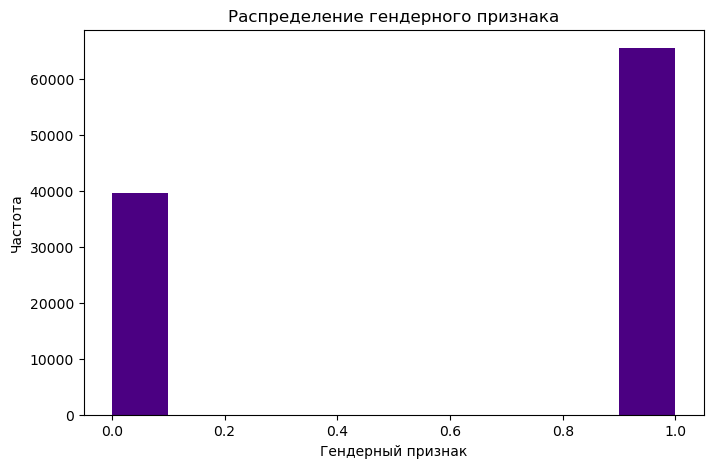

In [39]:
plt.figure(figsize=(8, 5))
plt.hist(df_personal_.gender, color='indigo')
plt.xlabel('Гендерный признак')
plt.ylabel('Частота')
plt.title('Распределение гендерного признака');

In [40]:
df_personal_.shape

(104989, 7)

In [41]:
# распределение гендерного признака покупателей

gender_count = df_personal_.groupby('gender', as_index=False).agg(gender_count=('id', 'count'))

gender_count["gender"] = gender_count["gender"].astype('category')
gender_count["gender"] = gender_count.gender.cat.rename_categories({0: 'женщины', 1: 'мужчины'}).astype('str')
gender_count

,gender,gender_count
0,женщины,39546
1,мужчины,65443


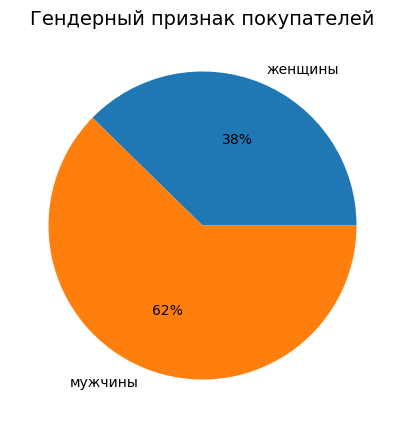

In [42]:
plt.figure(figsize=(10,5))
plt.pie(gender_count['gender_count'], labels = gender_count['gender'], autopct='%.0f%%') 
plt.title('Гендерный признак покупателей', fontsize=14)
plt.show()

In [43]:
# уникальные страны

df_personal_.country.unique()

array([32., 38., 35.,  5., 37., 33., 31.,  0., 39., 36., 51.,  6., 48.,
       28.,  8.,  7., 26.,  2., 14., 21., 41., 40.,  3.,  1., 18., 16.,
       49., 50., 43., 11., 22., 17., 15.])

In [44]:
# необходимо отфильтровать данные и оставить только тех людей, которые относятся к стране с кодовым цифровым значением 32

df_personal_ = df_personal_[df_personal_['country'] == 32]

In [45]:
df_personal_

,id,personal_coef,age,gender,education,city,country
0,0,0.5072,36.0,0.0,0,1201.0,32.0
1,4,0.5072,35.0,0.0,0,1134.0,32.0
2,6,0.4304,52.0,1.0,0,1188.0,32.0
3,7,0.5072,37.0,0.0,0,1198.0,32.0
4,9,0.5072,48.0,0.0,0,1134.0,32.0
...,...,...,...,...,...,...,...
104984,177942,0.4688,23.0,1.0,1,1134.0,32.0
104985,177955,0.4688,24.0,1.0,1,1193.0,32.0
104986,177968,0.4688,49.0,1.0,1,1157.0,32.0
104987,177984,0.5072,43.0,1.0,0,1204.0,32.0


In [46]:
df_personal_.shape

(104437, 7)

In [47]:
df_personal_.country.unique()

array([32.])

In [48]:
# purchases — данные о покупках: ID покупателя, название товара, цвет, стоимость, 
# гендерная принадлежность потенциальных покупателей товара, наличие скидки 
# (поле base_sale. Значение 1 соответствует наличию скидки на момент покупки) и дата покупки

In [49]:
df_purchases = pd.read_sql_query('SELECT id, \
                                 product, \
                                 CASE \
                                 WHEN product LIKE "%мужские%" THEN 1.0 \
                                 WHEN product LIKE "%мужская%" THEN 1.0 \
                                 WHEN product LIKE "%мужской%" THEN 1.0 \
                                 WHEN product LIKE "%мужское%" THEN 1.0 \
                                 WHEN product LIKE "%мужчин%" THEN 1.0 \
                                 WHEN product LIKE "%мужска%" THEN 1.0 \
                                 WHEN product LIKE "%женский%" THEN 0.0 \
                                 WHEN product LIKE "%женские%" THEN 0.0 \
                                 WHEN product LIKE "%женская%" THEN 0.0 \
                                 WHEN product LIKE "%женское%" THEN 0.0 \
                                 WHEN product LIKE "%женска%" THEN 0.0 \
                                 WHEN product LIKE "%детские%" THEN 2.0 \
                                 WHEN product LIKE "%детский%" THEN 2.0 \
                                 WHEN product LIKE "%детская%" THEN 2.0 \
                                 WHEN product LIKE "%девочек%" THEN 2.0 \
                                 WHEN product LIKE "%мальчиков%" THEN 2.0 \
                                 ELSE 3.0 \
                                 END AS product_sex_from_product, \
                                 colour, \
                                 CASE \
                                 WHEN colour LIKE "%/%" THEN "мультицвет" \
                                 WHEN colour LIKE "%-%" THEN substr(colour, instr(colour, "-") + 1) \
                                 WHEN colour IN ("PEL", "HTPK", "PEHL", "HPS", "S", "PK", "BG", "CB", "PWRT", "GSU", "FT", \
                                 "INC", "CH", "G", "HT", "C", "RBS", "DBP", "TR","SB", "ROL", "MBT", "GAU", "FTGPK", "BGH") \
                                 THEN "иной" \
                                 ELSE colour END AS "colour_main", \
                                 cost, product_sex, base_sale, dt \
                                 FROM purchases', conn)
# conn.close()

# 0.0 женское, 1.0 мужское, 2.0 детское, 3.0 иное (товары без конкретной гендерной принадлежности)

In [50]:
df_purchases.shape

(786260, 9)

In [51]:
df_purchases.head(5)

,id,product,product_sex_from_product,colour,colour_main,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",0.0,белый/синий,мультицвет,13599,0.0,1,7
1,0,Стол Outventure,3.0,зелёный,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,3.0,бежевый,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,1.0,белый,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,3.0,мультицвет,мультицвет,7199,NaN,0,27


In [52]:
df_purchases.shape

(786260, 9)

In [53]:
# товар по цене более 170 тысяч

VIP = df_purchases[df_purchases['cost'] > 170000]
VIP.head()

,id,product,product_sex_from_product,colour,colour_main,cost,product_sex,base_sale,dt
1401,381,Велосипед шоссейный Trek Emonda Alr 5 Disc 700...,3.0,серый/черный,мультицвет,199999,NaN,0,11
4833,1137,"Велосипед горный Merida One Sixty 400 27.5""",3.0,черный,черный,299999,NaN,0,36
5904,1391,Наклонная беговая дорожка NordicTrack Commerci...,3.0,чёрный/серый,мультицвет,299999,NaN,0,15
7597,1824,Наклонная беговая дорожка NordicTrack Commerci...,3.0,чёрный/серый,мультицвет,299999,NaN,0,15
15915,3682,"Велосипед горный Merida One Forty 700 27.5""",3.0,зеленый/красный,мультицвет,395999,NaN,0,52


In [54]:
VIP['product'].value_counts()

product
Велосипед горный Merida One Forty 700 27.5"                    66
Наклонная беговая дорожка NordicTrack Commercial X22i          39
Велосипед горный Merida One Forty 400 29"                      29
Велосипед горный Merida One Sixty 400 27.5"                    25
Эхолот Lowrance HDS-12 LIVE с датчиком Active Imaging 3-в-1    14
Тренажер гребной NordicTrack RW 900                            13
Велосипед шоссейный Trek Emonda Alr 5 Disc 700C, 2021           7
Эхолот Lowrance HDS-9 LIVE с датчиком Active Imaging 3-в-1      6
Беговая дорожка электрическая NordicTrack Commercial 2450       2
Велосипед шоссейный мужской Trek Domane SL 4 700C               1
Велосипед шоссейный Trek EMONDA SL 6 DISC 700C                  1
Беговая дорожка электрическая NordicTrack Commercial 2950       1
Картплоттер ECHOMAP UHD2 72sv                                   1
Велосипед горный Trek Roscoe 8 27.5", 2021                      1
Name: count, dtype: int64

In [55]:
# товар по цене более 400 тысяч

super_VIP = df_purchases[df_purchases['cost'] > 400000]
super_VIP.head()

,id,product,product_sex_from_product,colour,colour_main,cost,product_sex,base_sale,dt
23511,5319,Эхолот Lowrance HDS-12 LIVE с датчиком Active ...,3.0,None,None,446420,NaN,0,45
46020,10318,Эхолот Lowrance HDS-12 LIVE с датчиком Active ...,3.0,None,None,446420,NaN,0,49
49245,11072,"Велосипед горный Merida One Forty 700 27.5""",3.0,зеленый/красный,мультицвет,405999,NaN,0,23
51589,11613,Эхолот Lowrance HDS-12 LIVE с датчиком Active ...,3.0,None,None,446420,NaN,0,47
64475,14520,"Велосипед горный Merida One Forty 700 27.5""",3.0,зеленый/красный,мультицвет,405999,NaN,0,23


In [56]:
# количество товара

super_VIP['product'].value_counts()

product
Эхолот Lowrance HDS-12 LIVE с датчиком Active Imaging 3-в-1    14
Велосипед горный Merida One Forty 700 27.5"                     9
Name: count, dtype: int64

In [57]:
super_VIP.shape

(23, 9)

In [58]:
df_purchases[:5]

,id,product,product_sex_from_product,colour,colour_main,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",0.0,белый/синий,мультицвет,13599,0.0,1,7
1,0,Стол Outventure,3.0,зелёный,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,3.0,бежевый,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,1.0,белый,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,3.0,мультицвет,мультицвет,7199,NaN,0,27


In [62]:
# посмотрим на структуру строки

df_purchases['product'].tolist()[0:10]

['Велосипед горный женский Stern Mira 2.0 26"',
 'Стол Outventure',
 'Набор Outventure: стол + 4 стула',
 'Бутсы мужские GSD Astro',
 'Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALITY PRO',
 'Кеды мужские FILA A-Low',
 'Полуботинки мужские Outventure Chase',
 'Роликовые коньки детские Roces Orlando III',
 'Шлем FILA NRK FUN',
 'Роликовые коньки детские Roces Yuma TIF']

In [63]:
# количество уникальных товаров

df_purchases['product'].nunique()

23145

#### Feature engineering

In [64]:
# сформируем новый столбец short_product

df_purchases['short_product'] = df_purchases['product'].apply(lambda x: ' '.join(x.lower().split(' ')[0:2]).replace(' для', ''))

In [65]:
df_purchases.head(5)

,id,product,product_sex_from_product,colour,colour_main,cost,product_sex,base_sale,dt,short_product
0,0,"Велосипед горный женский Stern Mira 2.0 26""",0.0,белый/синий,мультицвет,13599,0.0,1,7,велосипед горный
1,0,Стол Outventure,3.0,зелёный,зелёный,1499,NaN,0,37,стол outventure
2,0,Набор Outventure: стол + 4 стула,3.0,бежевый,бежевый,4799,NaN,0,37,набор outventure:
3,3,Бутсы мужские GSD Astro,1.0,белый,белый,1599,1.0,0,13,бутсы мужские
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,3.0,мультицвет,мультицвет,7199,NaN,0,27,мяч футбольный


In [66]:
# количество уникальных товаров в short_product

df_purchases['short_product'].nunique()

2914

In [69]:
# список уникальных товаров в short_product

df_purchases['short_product'].unique().tolist()[:10]

['велосипед горный',
 'стол outventure',
 'набор outventure:',
 'бутсы мужские',
 'мяч футбольный',
 'кеды мужские',
 'полуботинки мужские',
 'роликовые коньки',
 'шлем fila',
 'набор защиты']

In [70]:
# количество пустых значений

df_purchases.isna().sum()

id                               0
product                          0
product_sex_from_product         0
colour                      119524
colour_main                 119524
cost                             0
product_sex                 314712
base_sale                        0
dt                               0
short_product                    0
dtype: int64

In [71]:
# заполним пустые значения

df_purchases['colour_main'] = df_purchases['colour_main'].fillna('иной')

In [72]:
df_purchases.isna().sum()

id                               0
product                          0
product_sex_from_product         0
colour                      119524
colour_main                      0
cost                             0
product_sex                 314712
base_sale                        0
dt                               0
short_product                    0
dtype: int64

In [73]:
# уникальные цвета

df_purchases['colour_main'].unique()

array(['мультицвет', 'зелёный', 'бежевый', 'белый', 'серый', 'розовый',
       'иной', 'черный', 'синий', 'чёрный', 'красный', 'жёлтый', 'желтый',
       'Черный', 'милитари', 'зеленый', 'коралловый', 'сливовый',
       'морской', 'ореховый', 'коричневый', 'голубой', 'баклажановый',
       'пионовый', 'фисташковый', 'терракотовый', 'фуксия', 'малиновый',
       'вишнёвый', 'графитовый', 'хаки', 'дымчатый', 'оливковый',
       'серебряный', 'еловый', 'сиреневый', 'болотный', 'небесный',
       'салатовый', 'бордовый', 'лиловый', 'лососевый', 'сапфировый',
       'кремовый', 'медный', 'оранжевый', 'прозрачный', 'васильковый',
       'алый', 'лавандовый', 'бирюзовый', 'охра', 'морковный', 'матовый',
       'лайм', 'фиолетовый', 'абрикосовый', 'ирис', 'черничный',
       'яблочный', 'мятный', 'серебристый', 'медовый', 'индиго',
       'фиалковый', 'кофейный', 'песочный', 'хвойный', 'какао',
       'персиковый', 'каштановый', 'изумрудный', 'орхидея', 'молочный',
       'Серый', 'Оранжевый',

In [74]:
df_purchases['colour_main'].nunique()

173

In [75]:
df_purchases['colour_main'] = df_purchases['colour_main'].apply(lambda x: x.lower().replace('ё', 'е'))

In [76]:
# количество уникальных цветов

df_purchases['colour_main'].nunique()

153

In [77]:
# распределение столбца product_sex

df_purchases.product_sex.value_counts(dropna=False)

product_sex
NaN    314712
1.0    271433
0.0    200115
Name: count, dtype: int64

In [78]:
# столбец product_sex_from_product полностью заполнен

df_purchases.product_sex_from_product.value_counts()

product_sex_from_product
1.0    271433
3.0    229144
0.0    199929
2.0     85754
Name: count, dtype: int64

In [79]:
# удалим неактуальные столбцы

df_purchases = df_purchases.drop(columns=['product', 'colour', 'product_sex'], axis=1)
df_purchases.head()

,id,product_sex_from_product,colour_main,cost,base_sale,dt,short_product
0,0,0.0,мультицвет,13599,1,7,велосипед горный
1,0,3.0,зеленый,1499,0,37,стол outventure
2,0,3.0,бежевый,4799,0,37,набор outventure:
3,3,1.0,белый,1599,0,13,бутсы мужские
4,3,3.0,мультицвет,7199,0,27,мяч футбольный


In [80]:
# пустых значений нет

df_purchases.isna().sum()

id                          0
product_sex_from_product    0
colour_main                 0
cost                        0
base_sale                   0
dt                          0
short_product               0
dtype: int64

In [81]:
# объединенный DataFrame - персональные данные и покупки по стране 32

df_pers_data_all_purchases = pd.merge(df_personal_, df_purchases, on='id', how='inner')
df_pers_data_all_purchases.head()

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный
1,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,зеленый,1499,0,37,стол outventure
2,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,бежевый,4799,0,37,набор outventure:
3,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,9199,0,0,роликовые коньки
4,4,0.5072,35.0,0.0,0,1134.0,32.0,3.0,белый,4999,0,0,шлем fila


In [83]:
df_pers_data_all_purchases.shape

(780117, 13)

In [85]:
# пустых значений не найдено

df_pers_data_all_purchases.isna().sum()

id                          0
personal_coef               0
age                         0
gender                      0
education                   0
city                        0
country                     0
product_sex_from_product    0
colour_main                 0
cost                        0
base_sale                   0
dt                          0
short_product               0
dtype: int64

#### Data Visualization

In [86]:
# отобразим разрядную сетку на графике

plt.rcParams['axes.grid'] = True

In [87]:
# посчитаем количество покупок по датам

data_purchase_count = df_pers_data_all_purchases[df_pers_data_all_purchases['dt'] != 0][['id', 'dt']].groupby('dt', as_index=False).agg(purchase_count=('id', 'count'))
data_purchase_count[:5]

,dt,purchase_count
0,1,18475
1,2,17820
2,3,18442
3,4,18707
4,5,14305


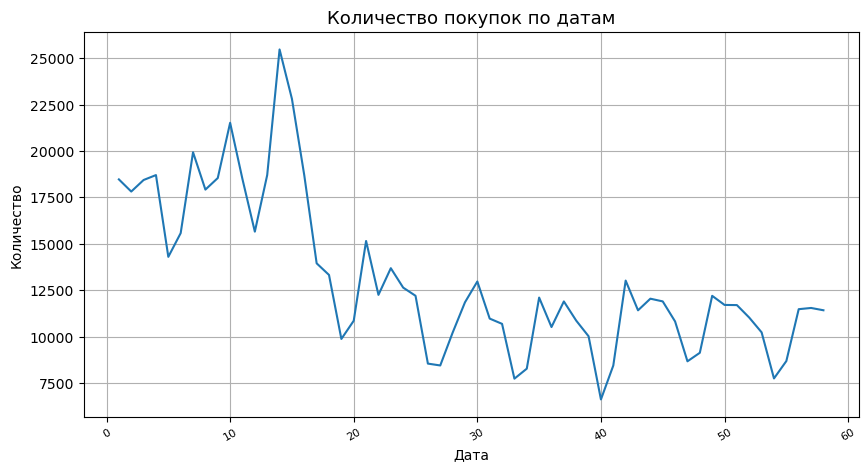

In [88]:
plt.figure(figsize=(10,5))
sns.lineplot(x='dt', y='purchase_count', data = data_purchase_count)
plt.title('Количество покупок по датам', fontsize=13)
plt.xticks(fontsize=8 ,rotation=30)
plt.xlabel('Дата', fontsize=10)
plt.ylabel('Количество', fontsize=10)
plt.show()

In [89]:
# количество приобретённых товаров (стоимость, превышающая 130000 (cost))

data_product_count = df_pers_data_all_purchases[(df_pers_data_all_purchases['dt'] != 0) & (df_pers_data_all_purchases['cost'] >= 130000)][['id', 'short_product']].groupby('short_product', as_index=False).agg(product_count=('id', 'count'))
data_product_count

,short_product,product_count
0,беговая дорожка,29
1,велосипед горный,199
2,велосипед шоссейный,138
3,картплоттер echomap,2
4,наклонная беговая,37
5,палатка 2-местная,9
6,палатка 3-местная,34
7,прикормочный кораблик,1
8,тренажер гребной,12
9,тренажер эллиптический,18


In [90]:
data_product_count.sort_values(by='product_count', inplace=True)

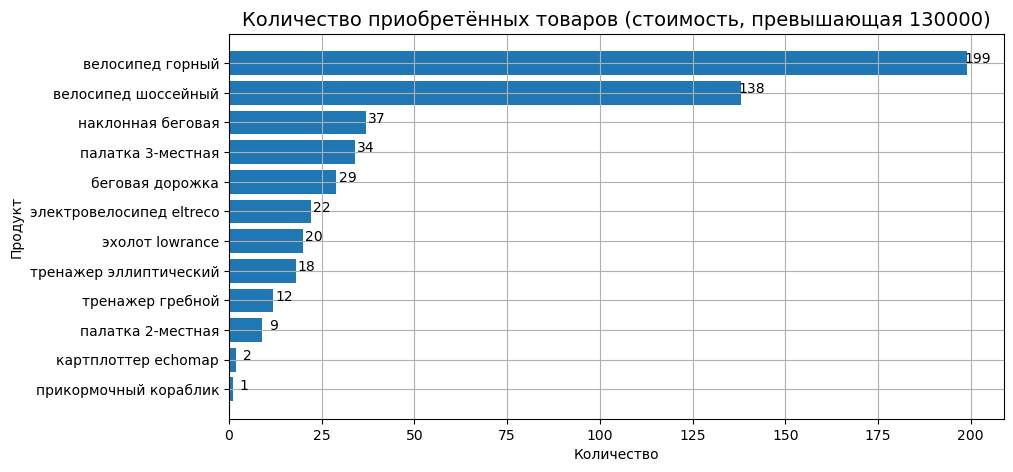

In [91]:
plt.figure(figsize=(10,5))
plt.barh(data_product_count['short_product'], data_product_count['product_count'])
plt.title('Количество приобретённых товаров (стоимость, превышающая 130000)', fontsize=14)
plt.xlabel('Количество')
plt.ylabel('Продукт')
for i, val in enumerate(data_product_count['product_count']):
    plt.text(x = val+3, y =i, s=str(val), ha='center')
plt.show()

In [92]:
# товары, которые покупают чаще всего, top-10

data_product_count_2 = df_pers_data_all_purchases[df_pers_data_all_purchases['dt'] != 0][['id', 'short_product']].groupby('short_product', as_index=False).agg(product_count=('id', 'count'))
data_product_count_2.sort_values(by='product_count', ascending=False, inplace=True)

In [93]:
top_10_products = data_product_count_2.head(10)
top_10_products

,short_product,product_count
1042,кроссовки мужские,58732
1041,кроссовки женские,29547
298,брюки мужские,23987
2621,футболка мужская,21725
1854,полуботинки мужские,20790
855,кеды мужские,19350
2828,шорты мужские,17028
293,брюки женские,15299
2618,футболка женская,14332
1033,кроссовки,11653


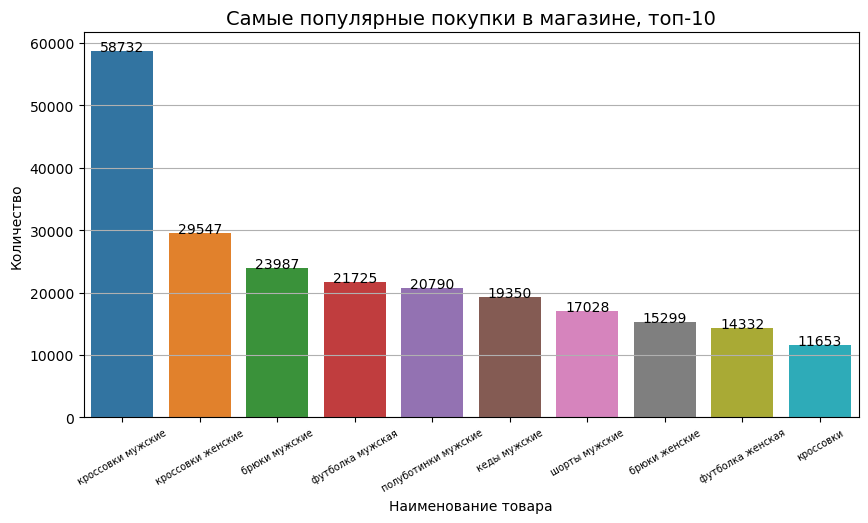

In [94]:
plt.figure(figsize=(10,5))
sns.barplot(x=top_10_products['short_product'], y=top_10_products['product_count'])
plt.title('Самые популярные покупки в магазине, топ-10', fontsize=14)
plt.xticks(rotation=30, fontsize=7)
plt.xlabel('Наименование товара')
plt.ylabel('Количество')
for i, val in enumerate(top_10_products['product_count']):
    plt.text(i, val+1, str(val), ha='center')
plt.show()

In [95]:
# статистика по образованию покупателей

education_per_client = df_pers_data_all_purchases[['id', 'education']].groupby(['id', 'education'], as_index=False).agg({'education': 'min'})
education_per_client

,id,education
0,0,0
1,3,0
2,4,0
3,6,0
4,7,0
...,...,...
104432,177998,0
104433,177999,0
104434,178001,0
104435,178002,0


In [96]:
education_count = education_per_client.groupby('education', as_index=False).agg(education_count=('id', 'count'))
education_count["education"] = education_count["education"].astype('category')
education_count["education"] = education_count.education.cat.rename_categories({0: 'среднее', 1: 'высшее'}).astype('str')
education_count

,education,education_count
0,среднее,81774
1,высшее,22663


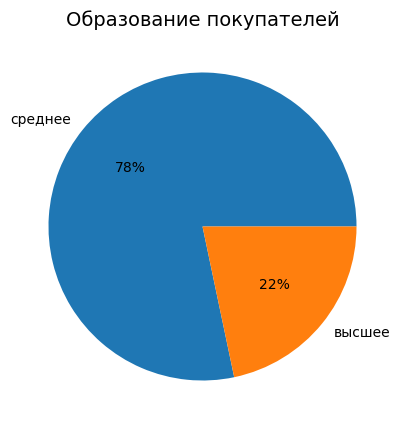

In [97]:
plt.figure(figsize=(10,5))
plt.pie(education_count['education_count'], labels = education_count['education'], autopct='%.0f%%') 
plt.title('Образование покупателей', fontsize=14)
plt.show()

In [98]:
df_pers_data_all_purchases[:3]

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный
1,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,зеленый,1499,0,37,стол outventure
2,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,бежевый,4799,0,37,набор outventure:


In [99]:
# топ-10 городов с самыми высокими объемами покупок

data_city = df_pers_data_all_purchases[df_pers_data_all_purchases['dt'] != 0].groupby('city', as_index=False).agg(city_sum_cost=('cost', 'sum')).sort_values('city_sum_cost', ascending=False).head(10)
data_city

,city,city_sum_cost
572,1134.0,1059577335
626,1188.0,468865205
595,1157.0,158551718
616,1178.0,142305005
605,1167.0,120075547
615,1177.0,115917884
642,1204.0,113877512
625,1187.0,87948740
639,1201.0,85709333
600,1162.0,78259298


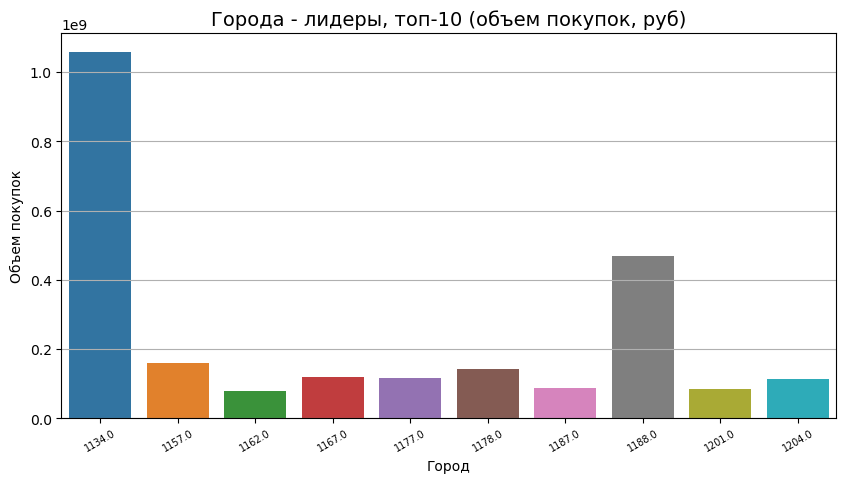

In [100]:
plt.figure(figsize=(10,5))
sns.barplot(x=data_city['city'], y=data_city['city_sum_cost'])
plt.title('Города - лидеры, топ-10 (объем покупок, руб)', fontsize=14)
plt.xticks(rotation=30, fontsize=7)
plt.xlabel('Город')
plt.ylabel('Объем покупок')
plt.show()

In [101]:
# количество уникальных покупателей

df_pers_data_all_purchases.id.nunique()

104437

In [102]:
# количество покупок за два месяца

df_pers_data_all_purchases.shape

(780117, 13)

## A/B testing

#### A/B testing (Data Preparation and Feature engineering)

In [114]:
# Первая кампания проводилась в период с 5-го по 16-й день, 
# ID участвовавших в ней пользователей содержатся в файле ids_first_company_positive.txt. 
# Эта кампания включала в себя предоставление персональной скидки 5 000 клиентов через email-рассылку

# изучим файл txt 

list_positive = []

with open('ids_first_company_positive.txt', 'r', encoding='UTF-8') as file:
    for i, content in enumerate(file.readlines()):
        if i >= 2:
            break
        list_positive.append(content)
        print(content)  
        

Ids of positive AB people 88128,171960,142117,114589,146123,94080,170921,63395,113075,144095,160909,28409,564,73304,17325,157790,73503,34595,27363,93721,53448,172382,139930,125612,123890,44798,98385,101786,19213,63220,34646,16476,166187,140056,161638,107475,97026,16112,115991,124787,156828,126921,141119,115620,140837,149500,44921,85789,22927,9984,32189,76510,70726,95757,91876,66688,87987,139301,121669,158721,96365,172608,135512,9374,81980,172855,164024,24755,19656,100382,64244,164113,95935,57430,86793,146767,85744,109125,22588,18792,82490,78167,9575,80270,24922,13188,131219,135219,125439,155222,54407,112736,91207,81815,17215,136729,34887,34327,91299,147422,33146,10367,72703,146648,142790,162520,64215,53979,60330,29616,46917,94944,37777,842,173346,114329,23065,93730,95418,76520,121995,49630,35415,169037,122653,46979,127692,69577,103191,137483,138630,25626,102468,30823,142371,90951,13321,122316,42861,166060,114482,120726,77077,110314,110119,73184,130753,64033,72535,58951,76522,57385,8625

In [115]:
df = pd.read_excel('positive.xlsx', header=None)
df = df.rename(columns={0: 'column'})

In [116]:
df.head()

,column
0,"Ids of positive AB people 88128,171960,142117,..."
1,"4,169500,98299,23240,103766,20571,42302,115462..."
2,",138094,45669,133480,169296,153545,69827,13902..."
3,"58,22893,23806,8030,56916,34715,118350,88907,1..."
4,",66763,11166,12919,138919,120005,152259,144006..."


In [117]:
df['column'] = df['column'].apply(lambda x: x.replace(';', ',').replace(' ', ',').split(',')).tolist()

In [135]:
df.head()

,column
0,"[Ids, of, positive, AB, people, 88128, 171960,..."
1,"[4, 169500, 98299, 23240, 103766, 20571, 42302..."
2,"[, 138094, 45669, 133480, 169296, 153545, 6982..."
3,"[58, 22893, 23806, 8030, 56916, 34715, 118350,..."
4,"[, 66763, 11166, 12919, 138919, 120005, 152259..."


In [136]:
list_1 = []

for row in df.itertuples():
    list_1.extend(row[1])
print(list_1[:20])    

['Ids', 'of', 'positive', 'AB', 'people', '88128', '171960', '142117', '114589', '146123', '94080', '170921', '63395', '113075', '144095', '160909', '28409', '564', '73304', '17325']


In [137]:
sorted(list_1)[:20]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '0',
 '0',
 '1',
 '1',
 '100029',
 '100036',
 '10010',
 '100121',
 '100129',
 '100147',
 '100182',
 '100184']

In [138]:
# если число, добавляем в список

list_1 = [int(x) for x in list_1 if x.isdigit()]


In [139]:
list_1[:20]

[88128,
 171960,
 142117,
 114589,
 146123,
 94080,
 170921,
 63395,
 113075,
 144095,
 160909,
 28409,
 564,
 73304,
 17325,
 157790,
 73503,
 34595,
 27363,
 93721]

In [143]:
# ids_first_company_positive

sorted(list_1)[:20]

[0, 0, 1, 1, 4, 5, 6, 9, 13, 18, 23, 30, 48, 58, 67, 83, 85, 92, 95, 105]

In [144]:
# 1 если клиенту была направлена скидка, 0 в ином случае

df_pers_data_all_purchases['test_group'] = df_pers_data_all_purchases.apply(lambda x: 1 if x.id in (list_1) else 0, axis=1)


In [145]:
df_pers_data_all_purchases.test_group.value_counts()

test_group
0    716296
1     63821
Name: count, dtype: int64

In [146]:
# после группировки по id получилось, что персональная скидка была предложена 4987 чел

test_id = df_pers_data_all_purchases[df_pers_data_all_purchases.test_group == 1].groupby('id', as_index=False).agg({'test_group':'count'})
test_id

,id,test_group
0,0,3
1,4,7
2,6,15
3,9,10
4,13,11
...,...,...
4982,177918,8
4983,177924,5
4984,177946,10
4985,177965,17


In [151]:
# Для проведения A/B-тестирования, помимо людей, которым предлагалась персональная скидка, 
# были отобраны люди со схожими социально-демографическими признаками и покупками, которым скидку не предложили. 
# ID этих клиентов лежат в аналогичном файле ids_first_company_negative.txt.

# изучим файл txt 

list_negative = []

with open('ids_first_company_negative.txt', 'r', encoding='UTF-8') as file:
    for i, content in enumerate(file.readlines()):
        if i >= 2:
            break
        list_negative.append(content)
        print(content)
 

Ids of negative AB people 82450;63400;7138;102118;153511;168450;4985;84106;83492;117102;168054;89820;62749;169114;161437;44626;170874;145877;161411;49035;56468;62835;77474;30013;55201;137781;165566;40819;101614;10027;84201;31128;96514;77779;142592;18314;48137;71286;128063;18550;70682;33862;52972;131507;45807;64262;164130;17193;108167;18712;77602;84851;33806;18813;168271;170144;141790;113883;175059;5199;67063;141940;63783;131035;29957;25195;150669;15874;8169;45630;50600;106224;114977;140090;29442;161833;156705;145568;173736;108499;145410;144617;74871;9397;43075;59380;123287;31406;135979;43728;98303;3014;164228;75809;155457;119551;7686;147106;134089;13702;136287;38219;27306;151342;97168;151349;136909;71823;162474;54410;24733;21599;89106;99224;71567;60068;141713;157428;70764;94959;77332;33517;129256;154873;94587;43729;38884;122120;137230;173829;49659;141221;154214;44269;38789;26923;26151;38744;160298;152524;147251;8225;113396;43129;83817;26930;127937;124424;142832;137831;88209;152761;1650

In [164]:
df2 = pd.read_excel('negative.xlsx', header=None)
df2 = df2.rename(columns={0: 'column'})
df2[:6]

,column
0,Ids of negative AB people 82450;63400;7138;102...
1,30;53388;103852;84418;154089;72849;155429;1293...
2,;11137;3216;72523;128190;20907;12177;54379;626...
3,;110401;99833;58331;42537;170964;5982;82247;59...
4,47609;48675;72952;30034;19980;111145;13540;152...
5,;96877;29371;64951;117521;151465;98239;145692;...


In [165]:
df2['column'] = df2['column'].apply(lambda x: str(x))
df2[:6]

,column
0,Ids of negative AB people 82450;63400;7138;102...
1,30;53388;103852;84418;154089;72849;155429;1293...
2,;11137;3216;72523;128190;20907;12177;54379;626...
3,;110401;99833;58331;42537;170964;5982;82247;59...
4,47609;48675;72952;30034;19980;111145;13540;152...
5,;96877;29371;64951;117521;151465;98239;145692;...


In [166]:
df2['column'] = df2['column'].apply(lambda x: x.replace(';', ',').replace('|||', ',').replace(' ', ',').split(',')).tolist()
                                

In [167]:
df2.head()

,column
0,"[Ids, of, negative, AB, people, 82450, 63400, ..."
1,"[30, 53388, 103852, 84418, 154089, 72849, 1554..."
2,"[, 11137, 3216, 72523, 128190, 20907, 12177, 5..."
3,"[, 110401, 99833, 58331, 42537, 170964, 5982, ..."
4,"[47609, 48675, 72952, 30034, 19980, 111145, 13..."


In [168]:
list_2 = []

for row in df2.itertuples():
    list_2.extend(row[1])
print(list_2[:20])

['Ids', 'of', 'negative', 'AB', 'people', '82450', '63400', '7138', '102118', '153511', '168450', '4985', '84106', '83492', '117102', '168054', '89820', '62749', '169114', '161437']


In [169]:
sorted(list_2)[:20]

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [170]:
list_2 = [int(x) for x in list_2 if x.isdigit()]

In [172]:
list_2[:20]

[82450,
 63400,
 7138,
 102118,
 153511,
 168450,
 4985,
 84106,
 83492,
 117102,
 168054,
 89820,
 62749,
 169114,
 161437,
 44626,
 170874,
 145877,
 161411,
 49035]

In [174]:
# ids_first_company_negative

sorted(list_2)[:20]

[1, 1, 1, 1, 3, 5, 5, 8, 9, 13, 13, 23, 30, 34, 39, 70, 75, 75, 80, 83]

In [175]:
df_pers_data_all_purchases['control_group'] = df_pers_data_all_purchases.apply(lambda x: 1 if x.id in (list_2) else 0, axis=1)

In [176]:
df_pers_data_all_purchases.control_group.value_counts()

control_group
0    724607
1     55510
Name: count, dtype: int64

In [177]:
# после группировки по id получилось, что персональная скидка НЕ была предложена 4950 чел

control_id = df_pers_data_all_purchases[df_pers_data_all_purchases.control_group == 1].groupby('id', as_index=False).agg({'control_group':'count'})
control_id

,id,control_group
0,3,4
1,9,10
2,13,11
3,23,3
4,30,2
...,...,...
4945,177764,6
4946,177839,3
4947,177899,5
4948,177963,5


In [178]:
# период - два месяца
# если дата покупки ноль, значит факта покупки не было

sorted(df_pers_data_all_purchases['dt'].unique().tolist())

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58]

In [179]:
# 19848 записей с датой покупки ноль, т.е. факта покупки не было (посмотрел, не купил)

df_pers_data_all_purchases[df_pers_data_all_purchases['dt'] == 0]

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group
3,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,9199,0,0,роликовые коньки,1,0
4,4,0.5072,35.0,0.0,0,1134.0,32.0,3.0,белый,4999,0,0,шлем fila,1,0
99,21,0.5584,19.0,0.0,1,1198.0,32.0,0.0,мультицвет,8499,0,0,кеды женские,0,0
157,49,0.4304,62.0,1.0,0,1181.0,32.0,1.0,серый,5999,0,0,брюки мужские,0,0
175,50,0.5072,41.0,0.0,0,1172.0,32.0,3.0,зеленый,120999,0,0,палатка 3-местная,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779730,177256,0.2672,17.0,1.0,1,1205.0,32.0,3.0,белый,499,0,0,"носки demix,",0,0
779842,177511,0.4304,46.0,1.0,0,1189.0,32.0,1.0,синий,3149,1,0,кеды мужские,0,0
779994,177666,0.4304,34.0,1.0,0,1157.0,32.0,3.0,черный,29999,0,0,эллиптический тренажер,0,0
780095,177942,0.4688,23.0,1.0,1,1134.0,32.0,1.0,мультицвет,8999,0,0,бутсы мужские,0,0


In [180]:
# создаем новый столбец: 1 - если была покупка, 0 - если не было покупки

df_pers_data_all_purchases['fact_of_purchase'] = df_pers_data_all_purchases.apply(lambda x: 0 if x['dt'] == 0 else 1, axis=1)

In [181]:
df_pers_data_all_purchases

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1
1,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,зеленый,1499,0,37,стол outventure,1,0,1
2,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,бежевый,4799,0,37,набор outventure:,1,0,1
3,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,9199,0,0,роликовые коньки,1,0,0
4,4,0.5072,35.0,0.0,0,1134.0,32.0,3.0,белый,4999,0,0,шлем fila,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780112,177984,0.5072,43.0,1.0,0,1204.0,32.0,0.0,черный,2099,1,47,брюки утепленные,0,0,1
780113,177984,0.5072,43.0,1.0,0,1204.0,32.0,0.0,сливовый,3499,1,55,куртка утепленная,0,0,1
780114,178002,0.4304,50.0,1.0,0,1188.0,32.0,1.0,мультицвет,5999,0,0,кроссовки мужские,0,0,0
780115,178002,0.4304,50.0,1.0,0,1188.0,32.0,1.0,иной,3499,0,57,кеды мужские,0,0,1


In [182]:
# разбивка по факту покупки (1 - купил, 0 - нет)

df_pers_data_all_purchases.fact_of_purchase.value_counts()

fact_of_purchase
1    760269
0     19848
Name: count, dtype: int64

In [183]:
# разбивка по гендерному признаку (0 - женщина, 1 - мужчина)

df_pers_data_all_purchases.gender.value_counts()

gender
1.0    473704
0.0    306413
Name: count, dtype: int64

In [184]:
# только фактические покупки

gender_purchase = df_pers_data_all_purchases[df_pers_data_all_purchases['fact_of_purchase'] == 1]
gender_purchase

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1
1,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,зеленый,1499,0,37,стол outventure,1,0,1
2,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,бежевый,4799,0,37,набор outventure:,1,0,1
5,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,6999,0,1,роликовые коньки,1,0,1
6,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,999,0,1,набор защиты,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780111,177984,0.5072,43.0,1.0,0,1204.0,32.0,1.0,иной,1299,0,44,свитшот мужской,0,0,1
780112,177984,0.5072,43.0,1.0,0,1204.0,32.0,0.0,черный,2099,1,47,брюки утепленные,0,0,1
780113,177984,0.5072,43.0,1.0,0,1204.0,32.0,0.0,сливовый,3499,1,55,куртка утепленная,0,0,1
780115,178002,0.4304,50.0,1.0,0,1188.0,32.0,1.0,иной,3499,0,57,кеды мужские,0,0,1


In [185]:
# разбивка по гендеру с фактической покупкой
# в этом магазине мужчины покупают на бОльшие суммы, чем женщины

gender_purchase[['gender', 'cost']].groupby('gender')['cost'].sum()

gender
0.0    1251520619
1.0    2850753496
Name: cost, dtype: int64

In [186]:
# изучим конверсии и зависимости покупки от признаков

df_conv = df_pers_data_all_purchases['fact_of_purchase'].mean()
df_conv

0.9745576625044705

In [187]:
df_conv2 = df_pers_data_all_purchases[df_pers_data_all_purchases['fact_of_purchase'] == 1]['fact_of_purchase'].sum() / len(df_pers_data_all_purchases)
df_conv2

0.9745576625044705

In [188]:
# в этом магазине мужчины фактически покупают чаще и больше, чем женщины

df_conv_gender = gender_purchase[['gender', 'fact_of_purchase', 'cost']].groupby('gender', as_index=False).agg({'fact_of_purchase': 'sum', 'cost': 'sum'})
df_conv_gender

,gender,fact_of_purchase,cost
0,0.0,298543,1251520619
1,1.0,461726,2850753496


In [189]:
# зависимость покупки от гендерной принадлежности товара (потенциальных покупателей товара)

df_conv_product_sex_from_product = df_pers_data_all_purchases[['product_sex_from_product', 'fact_of_purchase']].groupby('product_sex_from_product').mean()
df_conv_product_sex_from_product

,fact_of_purchase
product_sex_from_product,
0.0,0.973268
1.0,0.974687
2.0,0.972596
3.0,0.976257


In [190]:
# зависимость покупки от образования

df_conv_education = df_pers_data_all_purchases[['education', 'fact_of_purchase']].groupby('education').mean()
df_conv_education

,fact_of_purchase
education,
0,0.974157
1,0.976159


In [191]:
# зависимость покупки от скидки base_sale ( 1 - наличие скидки на момент покупки, 0 - нет)
# с base_sale покупают больше

df_conv_base_sale = df_pers_data_all_purchases[['base_sale', 'fact_of_purchase']].groupby('base_sale').mean()
df_conv_base_sale

,fact_of_purchase
base_sale,
0,0.970407
1,0.982057


In [192]:
# группировка по клиенту, ничего не покупал - 0, что то покупал - 1

df_conv_by_id = df_pers_data_all_purchases[['id', 'fact_of_purchase']].groupby('id', as_index=False)['fact_of_purchase'].min()
df_conv_by_id

,id,fact_of_purchase
0,0,1
1,3,1
2,4,0
3,6,1
4,7,1
...,...,...
104432,177998,1
104433,177999,1
104434,178001,1
104435,178002,0


In [193]:
# конверсия в покупку по клиенту (уникальному id)

df_conv_by_id['fact_of_purchase'].sum() / len(df_conv_by_id)

0.8771795436483238

In [194]:
df_pers_data_all_purchases[:2]

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1
1,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,зеленый,1499,0,37,стол outventure,1,0,1


#### A/B test

In [195]:
# Кейс: анализ проведения кампании в период с 5-го по 16-й день. 
# Кампания включала в себя предоставление персональной скидки 5 000 клиентов через email-рассылку.

In [196]:
df_control_test = df_pers_data_all_purchases.copy()

In [197]:
# выборка только клиентов с покупкой, которые вошли в группу control и в test

df_control_test = df_control_test[((df_control_test['test_group'] == 1) |
                               (df_control_test['control_group'] == 1)) &
                                  (df_control_test['fact_of_purchase'] == 1)][['id', 'base_sale', 'test_group', 'control_group', 'fact_of_purchase', 'cost', 'dt']]

df_control_test

,id,base_sale,test_group,control_group,fact_of_purchase,cost,dt
0,0,1,1,0,1,13599,7
1,0,0,1,0,1,1499,37
2,0,0,1,0,1,4799,37
5,4,0,1,0,1,6999,1
6,4,0,1,0,1,999,1
...,...,...,...,...,...,...,...
779906,177534,0,1,0,1,1799,49
780069,177906,0,1,0,1,2799,2
780070,177906,0,1,0,1,1999,7
780071,177906,0,1,0,1,18490,21


In [198]:
df_control_test.shape

(116922, 7)

In [199]:
# обнаружены пять id (9, 13, 23, 30, 83), которые присутствуют и в control и в test, удалим их

df_control_test[(df_control_test['test_group'] == 1) & (df_control_test['control_group'] == 1)].groupby('id')['fact_of_purchase'].count()

id
9     10
13    11
23     3
30     2
83     3
Name: fact_of_purchase, dtype: int64

In [200]:
# control и test группы совокупно содержат около 117000 покупок

df_control_test = df_control_test[(df_control_test['id'] != 9) & (df_control_test['id'] != 13) & (df_control_test['id'] != 23) & 
                    (df_control_test['id'] != 30) & (df_control_test['id'] != 83)]
df_control_test

,id,base_sale,test_group,control_group,fact_of_purchase,cost,dt
0,0,1,1,0,1,13599,7
1,0,0,1,0,1,1499,37
2,0,0,1,0,1,4799,37
5,4,0,1,0,1,6999,1
6,4,0,1,0,1,999,1
...,...,...,...,...,...,...,...
779906,177534,0,1,0,1,1799,49
780069,177906,0,1,0,1,2799,2
780070,177906,0,1,0,1,1999,7
780071,177906,0,1,0,1,18490,21


In [201]:
# выбираем участников первой кампании, которая проводилась в период с 5-го по 16-й день 

df_5_16_day = df_control_test[(df_control_test['dt'] >= 5) & (df_control_test['dt'] <= 16)]
                                                                       
df_5_16_day

,id,base_sale,test_group,control_group,fact_of_purchase,cost,dt
0,0,1,1,0,1,13599,7
12,6,0,1,0,1,999,8
13,6,1,1,0,1,1119,11
14,6,0,1,0,1,299,11
15,6,0,1,0,1,7399,11
...,...,...,...,...,...,...,...
779884,177529,0,0,1,1,6999,13
779885,177529,0,0,1,1,15999,16
779886,177529,0,0,1,1,13999,16
779901,177534,0,1,0,1,7699,15


In [202]:
sorted(df_5_16_day.dt.unique())

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [203]:
# выборка для A/B теста НЕ должна содержать клиентов с base_sale ( это иная скидка, которая не входит 
# в кампанию персональной скидки через через email-рассылку в период с 5-го по 16-й день ) и может искажать результаты A/B

# reminder: поле base_sale. Значение 1 соответствует наличию скидки на момент покупки

In [204]:
# итоговая контрольная группа (не берем в нее тех, у кого была иная скидка base_sale)
# будем считать средний чек по клиенту

df_5_16_day_control = df_5_16_day[(df_5_16_day['control_group'] == 1) & (df_5_16_day['base_sale'] == 0)][['id', 'cost']].groupby(['id'], as_index=False).agg({'cost': 'sum'})
df_5_16_day_control

,id,cost
0,3,1599
1,70,9998
2,75,6498
3,87,10997
4,126,34595
...,...,...
4388,177664,5999
4389,177711,8408
4390,177764,8298
4391,177839,56798


In [205]:
df_5_16_day_control.shape

(4393, 2)

In [206]:
df_5_16_day_control.id.nunique()

4393

In [207]:
# итоговая тестовая группа (не берем в нее тех, у кого была иная скидка base_sale)

df_5_16_day_test = df_5_16_day[(df_5_16_day['test_group'] == 1) & (df_5_16_day['base_sale'] == 0)][['id', 'cost']].groupby(['id'], as_index=False).agg({'cost': 'sum'})
df_5_16_day_test

,id,cost
0,6,16096
1,18,26736
2,58,2799
3,67,4123
4,85,2449
...,...,...
4463,177918,4897
4464,177924,8996
4465,177946,28698
4466,177965,22093


In [208]:
df_5_16_day_test.shape

(4468, 2)

In [209]:
df_5_16_day_test.id.nunique()

4468

In [210]:
# сумма покупок в группе control

df_5_16_day_control.cost.sum()

89067479

In [211]:
# сумма покупок в группе test

df_5_16_day_test.cost.sum()

104745940

In [212]:
# Sample ratio mismatch test (несоответствие кол-ва покупателей в группах)

test = df_5_16_day_test.shape[0]        # 4468
control = df_5_16_day_control.shape[0]  # 4393

total_traffic = test + control

In [213]:
observed = [test, control] # наблюдаемые
observed

[4468, 4393]

In [214]:
expected = [total_traffic / 2, total_traffic / 2] # ожидаемые, сплит-разделение 50 на 50 на две группы
expected

[4430.5, 4430.5]

In [215]:
# воспользуемся Хи-квадрат

chi = chisquare(observed, f_exp = expected)
print(chi)

Power_divergenceResult(statistic=0.6348041981717639, pvalue=0.4255985589923036)


In [216]:
if chi[1] < 0.01:
    print('SRM may be present') # несоответствие групп возможно есть
else:
    print('SRM may not be present')   # несоответствие групп статистически незначимо

SRM may not be present


In [217]:
# дисбаланс в группах статистически незначимый

#### A/B testing (hypotheses)

In [218]:
# Наличие/отсутствие изменений проверяем через A/B-тест:

# контрольная группа без изменений
# control покупатели без скидки


# тестовая группа с изменениями
# test покупатели со скидкой

In [219]:
# гипотеза превосходства ( со скидкой покупают больше, чем без нее )

# H0 - Нулевая Гипотеза

# Клиенты со скидкой в среднем покупают также, как клиенты без скидки (распределения равны)
# Среднее в группе control и в группе test равно (средний чек не имеет статистически значимых различий)


# H1 - Альтернативная Гипотеза

# Между клиентами, которые получили скидку и клиентами, которые покупали без скидки есть разница
# между тестовой и контрольной группами есть разница

# Дополнительная альтернативная гипотеза (two-tailed test)
# Клиенты без скидки в среднем покупают меньше, чем клиенты со скидкой 
# (т.е. распределение клиентов без скидки стохастически меньше, чем распределение клиентов со скидкой)


In [220]:
# Метрики, по которым будем оценивать эксперимент (что хотим улучшить):  
# Средний чек


# Контр-метрики (что хотим не уронить):
# Количество покупок

# alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнаем гипотезу

In [221]:
# тест Шапиро - Уилка на выборках (проверка распределения)

In [222]:
stats.shapiro(df_5_16_day_control['cost'])

ShapiroResult(statistic=0.45740073919296265, pvalue=0.0)

In [223]:
# pvalue ниже уровня значимости 0,05, значит отвергаем нулевую гипотезу о том, что данные распределены нормально

In [224]:
stats.shapiro(df_5_16_day_test['cost'])

ShapiroResult(statistic=0.4943121671676636, pvalue=0.0)

In [225]:
# pvalue ниже уровня значимости 0,05, значит отвергаем нулевую гипотезу о том, что данные распределены нормально

In [226]:
# Проверка статистической значимости: необходимо убедиться, что различия между контрольной и тестовой группами 
# не являются случайными. 

# Если различия статистически значимы, то можно считать, что изменения, внесенные в тестовую группу, 
# действительно влияют на показатели.

In [227]:
# с учетом ненормального распределения и независимости выборок
# расчёт критерия Манна — Уитни:

stats.mannwhitneyu(df_5_16_day_control['cost'], df_5_16_day_test['cost'])

MannwhitneyuResult(statistic=8739476.0, pvalue=4.4718103371463815e-19)

In [228]:
# pvalue ниже уровня значимости 0,05, можем отвергнуть нулевую гипотезу в пользу альтернативной, control и test не равны

In [229]:
# значение pvalue оказалось большим, мы не можем отвергнуть нулевую гипотезу

stats.mannwhitneyu(df_5_16_day_control['cost'], df_5_16_day_test['cost'], alternative = 'greater')

MannwhitneyuResult(statistic=8739476.0, pvalue=1.0)

In [230]:
# в данном случае значение pvalue значительно меньше 5%, а это значит, что мы можем отвергнуть нулевую гипотезу, 
# различия статистически значимы, средние не равны

# среднее в группе control ниже, чем в группе test, т.е. среднее покупателей, которым НЕ была предоставлена персональная скидка 
# через email-рассылку ниже, чем у тех покупателей, кому скидка была предоставлена

stats.mannwhitneyu(df_5_16_day_control['cost'], df_5_16_day_test['cost'], alternative = 'less')

MannwhitneyuResult(statistic=8739476.0, pvalue=2.2359051685731907e-19)

In [231]:
# Наличие скидки увеличивает средний чек клиента

#### A/B testing (control and test group metrics)

In [232]:
conv_control = df_pers_data_all_purchases[(df_pers_data_all_purchases['control_group'] == 1) & 
                                               (df_pers_data_all_purchases['base_sale'] == 0) & 
                                               (df_pers_data_all_purchases['dt'] >= 5) & 
                                               (df_pers_data_all_purchases['dt'] <=16)]


conv_control = conv_control[(conv_control['id'] != 9) & (conv_control['id'] != 13) & (conv_control['id'] != 23) & 
                    (conv_control['id'] != 30) & (conv_control['id'] != 83)]
conv_control

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase
239,70,0.5584,31.0,0.0,1,1185.0,32.0,0.0,графитовый,3999,0,5,сандалии женские,0,1,1
240,70,0.5584,31.0,0.0,1,1185.0,32.0,1.0,хаки,5999,0,16,кроссовки мужские,0,1,1
292,87,0.5072,52.0,0.0,0,1202.0,32.0,2.0,синий,1599,0,10,бутсы,0,1,1
293,87,0.5072,52.0,0.0,0,1202.0,32.0,2.0,синий,3899,0,14,борцовки,0,1,1
294,87,0.5072,52.0,0.0,0,1202.0,32.0,2.0,мультицвет,5499,0,14,сандалии детские,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779882,177529,0.5072,51.0,0.0,0,182.0,32.0,0.0,черный,15999,0,13,полуботинки женские,0,1,1
779883,177529,0.5072,51.0,0.0,0,182.0,32.0,3.0,иной,2299,0,13,спортивный топ,0,1,1
779884,177529,0.5072,51.0,0.0,0,182.0,32.0,0.0,иной,6999,0,13,кроссовки женские,0,1,1
779885,177529,0.5072,51.0,0.0,0,182.0,32.0,0.0,иной,15999,0,16,полуботинки женские,0,1,1


In [233]:
# количество покупок в группе control

conv_control['fact_of_purchase'].value_counts()

fact_of_purchase
1    13866
Name: count, dtype: int64

In [234]:
conv_test = df_pers_data_all_purchases[(df_pers_data_all_purchases['test_group'] == 1) & 
                                            (df_pers_data_all_purchases['base_sale'] == 0) &
                                            (df_pers_data_all_purchases['dt'] >= 5) & 
                                            (df_pers_data_all_purchases['dt'] <=16)]
conv_test = conv_test[(conv_test['id'] != 9) & (conv_test['id'] != 13) & (conv_test['id'] != 23) & 
                    (conv_test['id'] != 30) & (conv_test['id'] != 83)]
conv_test

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase
12,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,синий,999,0,8,футболка мужская,1,0,1
14,6,0.4304,52.0,1.0,0,1188.0,32.0,2.0,мультицвет,299,0,11,носки детские,1,0,1
15,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,черный,7399,0,11,кроссовки мужские,1,0,1
16,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,черный,7399,0,13,кроссовки мужские,1,0,1
74,18,0.4304,53.0,1.0,0,1188.0,32.0,1.0,черный,7199,0,11,ветровка мужская,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779753,177349,0.5072,39.0,1.0,0,1186.0,32.0,2.0,иной,3839,0,15,кроссовки,1,0,1
779754,177349,0.5072,39.0,1.0,0,1186.0,32.0,2.0,синий,249,0,15,футболка,1,0,1
779755,177349,0.5072,39.0,1.0,0,1186.0,32.0,2.0,иной,799,0,15,легинсы,1,0,1
779901,177534,0.4304,37.0,1.0,0,1196.0,32.0,1.0,иной,7699,0,15,бутсы мужские,1,0,1


In [235]:
# количество покупок в группе test

conv_test['fact_of_purchase'].value_counts()

fact_of_purchase
1    17451
Name: count, dtype: int64

In [236]:
# отношение количества покупок в группе control к общему объему покупок групп control и test 

conv_control['fact_of_purchase'].sum() / (len(conv_control) + len(conv_test))

0.4427627167353195

In [237]:
# отношение количества покупок в группе test к общему объему покупок групп control и test

conv_test['fact_of_purchase'].sum() / (len(conv_control) + len(conv_test))

0.5572372832646805

In [238]:
# количество покупок в группе клиентов с персональной скидкой увеличилось

In [239]:
# сумма покупок control

conv_control['cost'].sum()

89067479

In [240]:
# сумма покупок test

conv_test['cost'].sum()

104745940

In [241]:
# сумма покупок в группе клиентов с персональной скидкой увеличилось

In [242]:
# доход группы control за период на количество клиентов control 

conv_control['cost'].sum() / conv_control['id'].nunique()

20274.8643296153

In [243]:
# доход группы test за период на количество клиентов test

conv_test['cost'].sum() / conv_test['id'].nunique()

23443.585496866606

In [244]:
# средняя прибыль с одного клиента за конкретный период в группе клиентов с персональной скидкой увеличилась

In [245]:
# Итоги A/B теста:

# наличие скидки увеличивает средний чек клиента
# сумма покупок в тестовой группе (клиенты со скидкой) увеличилась, клиенты со скидкой покупают больше по сумме
# количество покупок в тестовой группе (клиенты со скидкой) увеличилось, клиенты со скидкой покупают больше товаров


## Cohort analysis

In [656]:
df_cohort = df_pers_data_all_purchases.copy()

In [657]:
# полный фрейм только с фактическими покупками за период с 1 до 25 дня

df_cohort = df_cohort[(df_cohort['fact_of_purchase'] == 1) & (df_cohort['dt'] <= 25)]
df_cohort

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1
5,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,6999,0,1,роликовые коньки,1,0,1
6,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,999,0,1,набор защиты,1,0,1
7,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,розовый,1499,0,2,шлем,1,0,1
8,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,4399,0,2,роликовые коньки,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780099,177942,0.4688,23.0,1.0,1,1134.0,32.0,3.0,белый,14999,0,21,мяч футбольный,0,0,1
780100,177955,0.4688,24.0,1.0,1,1193.0,32.0,3.0,серый,1819,1,4,сумка nike,0,0,1
780101,177955,0.4688,24.0,1.0,1,1193.0,32.0,2.0,розовый,899,0,4,бейсболка,0,0,1
780102,177955,0.4688,24.0,1.0,1,1193.0,32.0,2.0,серый,1299,0,5,бейсболка детская,0,0,1


In [658]:
df_cohort = df_cohort[['id', 'cost', 'dt']]
df_cohort

,id,cost,dt
0,0,13599,7
5,4,6999,1
6,4,999,1
7,4,1499,2
8,4,4399,2
...,...,...,...
780099,177942,14999,21
780100,177955,1819,4
780101,177955,899,4
780102,177955,1299,5


In [659]:
df_cohort['cohortDate'] = df_cohort.groupby('id')['dt'].transform('min')

C:\Users\Julia\AppData\Local\Temp\ipykernel_5916\4103489137.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cohort['cohortDate'] = df_cohort.groupby('id')['dt'].transform('min')


In [660]:
df_cohort.head()

,id,cost,dt,cohortDate
0,0,13599,7,7
5,4,6999,1,1
6,4,999,1,1
7,4,1499,2,1
8,4,4399,2,1


In [661]:
day_diff = df_cohort['dt'] - df_cohort['cohortDate']

In [662]:
# проставим когорты столбцом в датафрейме

df_cohort['cohort_index'] = day_diff+1

C:\Users\Julia\AppData\Local\Temp\ipykernel_5916\4033511433.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cohort['cohort_index'] = day_diff+1


In [663]:
df_cohort

,id,cost,dt,cohortDate,cohort_index
0,0,13599,7,7,1
5,4,6999,1,1,1
6,4,999,1,1,1
7,4,1499,2,1,2
8,4,4399,2,1,2
...,...,...,...,...,...
780099,177942,14999,21,1,21
780100,177955,1819,4,4,1
780101,177955,899,4,4,1
780102,177955,1299,5,4,2


In [664]:
# получилось 25 когорт, как первые 25 дней в изначальном датафрейме

# фактически этот индекс для каждой транзакции это кол-во дней от первой покупки до текущей 
# ( единица добавляется в формуле чтобы не получилось нулевое значение )

df_cohort['cohort_index'].unique()

array([ 1,  2,  3,  8, 11, 13, 17, 18,  9, 20,  4, 15, 16, 24,  6, 12,  5,
        7, 23, 10, 19, 14, 22, 21, 25], dtype=int64)

In [665]:
# КОГОРТНЫЙ АНАЛИЗ по количеству покупок

In [666]:
# все предыдущие действия были подготовкой, теперь сам когортный анализ
# получим классическую таблицу когортного анализа уголком

df_cohort1 = df_cohort.pivot_table(index='cohortDate',
                      columns='cohort_index',
                      values='id',
                      aggfunc=len)

In [667]:
# получили классическую таблицу когортного анализа
# в данном случае мы строим когортный анализ по кол-ву покупок, 
# в каждой строке мы видим кол-во покупок, разделенных по группам клиентов, которые пришли к нам в определенный день

df_cohort1

cohort_index,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
cohortDate,,,,,,,,,,,,,,,,,,,,,
1,18475.0,4191.0,3560.0,3343.0,2228.0,2220.0,3283.0,2990.0,2914.0,3121.0,...,2410.0,2196.0,2027.0,1246.0,1323.0,2266.0,1874.0,2147.0,1963.0,1933.0
2,13629.0,2505.0,2153.0,1415.0,1371.0,2045.0,1684.0,1768.0,2082.0,1735.0,...,1366.0,1263.0,922.0,1005.0,1581.0,1278.0,1405.0,1235.0,1336.0,NaN
3,12377.0,2263.0,1281.0,1243.0,1767.0,1476.0,1519.0,1618.0,1443.0,1010.0,...,1041.0,728.0,783.0,1256.0,1015.0,1095.0,1109.0,1096.0,NaN,NaN
4,10948.0,1326.0,1215.0,1529.0,1226.0,1188.0,1376.0,1164.0,915.0,1046.0,...,695.0,746.0,1061.0,870.0,995.0,987.0,872.0,NaN,NaN,NaN
5,8055.0,1362.0,920.0,763.0,899.0,797.0,781.0,931.0,1048.0,924.0,...,809.0,576.0,502.0,558.0,574.0,542.0,NaN,NaN,NaN,NaN
6,8171.0,1068.0,889.0,742.0,869.0,684.0,891.0,1123.0,947.0,824.0,...,621.0,514.0,577.0,557.0,485.0,NaN,NaN,NaN,NaN,NaN
7,9323.0,1446.0,1103.0,1260.0,970.0,643.0,724.0,1524.0,1232.0,963.0,...,719.0,862.0,732.0,658.0,NaN,NaN,NaN,NaN,NaN,NaN
8,7451.0,1261.0,1135.0,797.0,567.0,643.0,1068.0,944.0,753.0,590.0,...,627.0,620.0,573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,7153.0,1334.0,940.0,671.0,734.0,992.0,915.0,740.0,626.0,576.0,...,519.0,571.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [668]:
# все покупки от новых клиентов в первом столбце
# у клиентов максимальное количество покупок в день, когда они пришли впервые
# далее покупают меньше

In [669]:
# видоизменим таблицу чтобы посчитать данные в процентах, 
# т.е. вместо абсолютного количества заказов будем смотреть данные в процентах к первому дню

first_column=df_cohort1.iloc[:,0]

In [670]:
# retention - удержание

retention=df_cohort1.div(first_column,axis=0)

In [671]:
retention.round(2)

cohort_index,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
cohortDate,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.23,0.19,0.18,0.12,0.12,0.18,0.16,0.16,0.17,...,0.13,0.12,0.11,0.07,0.07,0.12,0.10,0.12,0.11,0.1
2,1.0,0.18,0.16,0.10,0.10,0.15,0.12,0.13,0.15,0.13,...,0.10,0.09,0.07,0.07,0.12,0.09,0.10,0.09,0.10,NaN
3,1.0,0.18,0.10,0.10,0.14,0.12,0.12,0.13,0.12,0.08,...,0.08,0.06,0.06,0.10,0.08,0.09,0.09,0.09,NaN,NaN
4,1.0,0.12,0.11,0.14,0.11,0.11,0.13,0.11,0.08,0.10,...,0.06,0.07,0.10,0.08,0.09,0.09,0.08,NaN,NaN,NaN
5,1.0,0.17,0.11,0.09,0.11,0.10,0.10,0.12,0.13,0.11,...,0.10,0.07,0.06,0.07,0.07,0.07,NaN,NaN,NaN,NaN
6,1.0,0.13,0.11,0.09,0.11,0.08,0.11,0.14,0.12,0.10,...,0.08,0.06,0.07,0.07,0.06,NaN,NaN,NaN,NaN,NaN
7,1.0,0.16,0.12,0.14,0.10,0.07,0.08,0.16,0.13,0.10,...,0.08,0.09,0.08,0.07,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.17,0.15,0.11,0.08,0.09,0.14,0.13,0.10,0.08,...,0.08,0.08,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.19,0.13,0.09,0.10,0.14,0.13,0.10,0.09,0.08,...,0.07,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [672]:
plt.rcParams['axes.grid'] = False

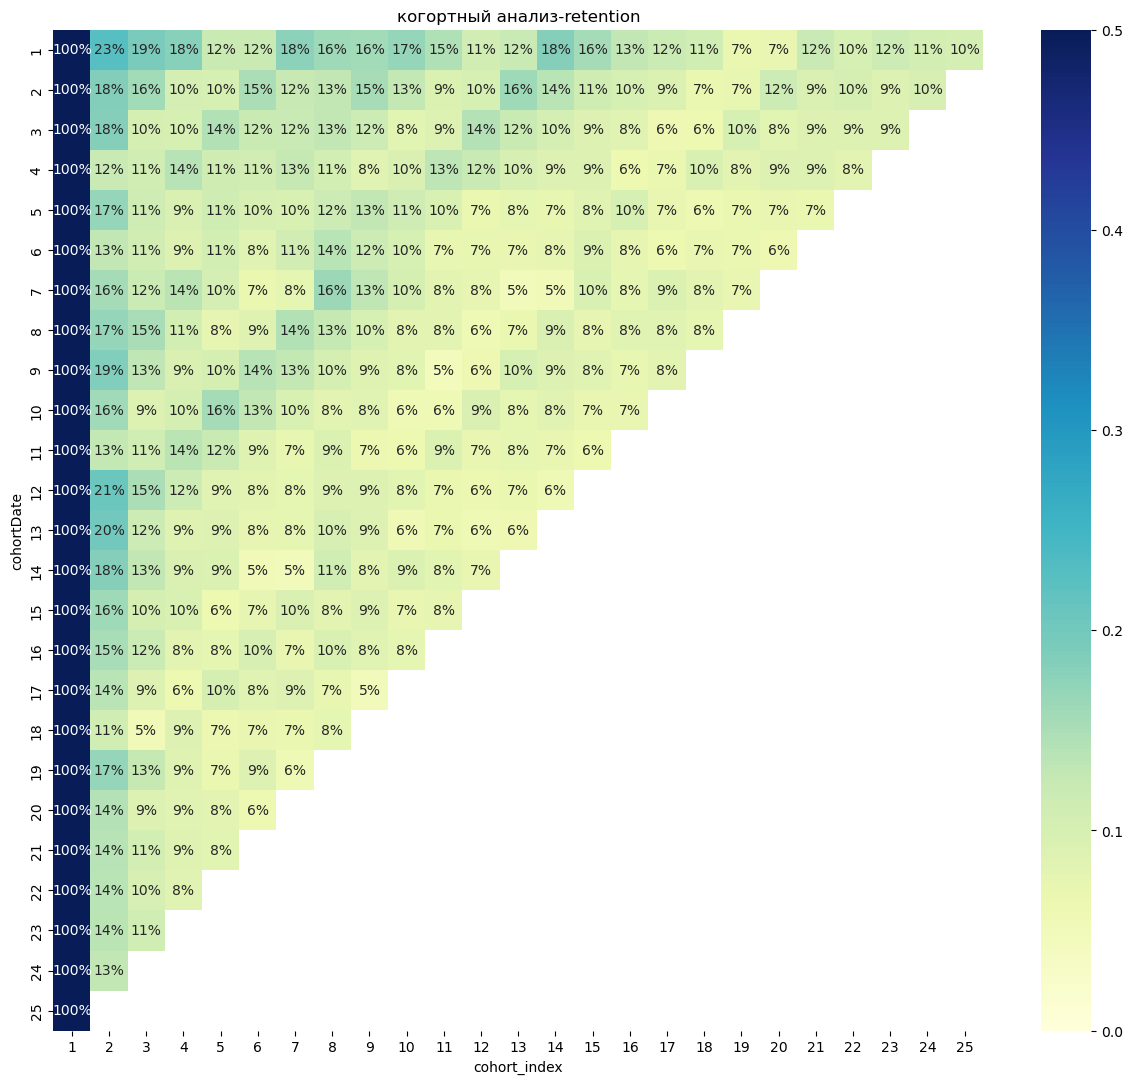

In [673]:
# отформатируем таблицу, чтобы с ней было удобно работать, cmap="YlGnBu" - это цвета, можно менять

plt.figure(figsize=(15,13))
plt.title('когортный анализ-retention')
sns.heatmap(data=retention,
           annot=True,
           fmt='.0%',
           vmin=0.0,
           vmax=0.5,
           cmap="YlGnBu")
plt.show()

In [674]:
# теперь в процентах видим как уменьшались покупки в каждой группе с течением дней

# уже на второй, третий день количество покупок сильно уменьшилось и далее уменьшалось,
# количество покупок в каждой группе сократилось от 100% до 6-10%

# клиенты совершают основые покупки в первый день посещения, далее отчетливо видно, что покупки по 16 чиcло значительно выше, 
# чем после 16 (Первая кампания проводилась в период с 5-го по 16-й день)
# далее после 16 дня кол-во покупок клиентов уменьшается до 6% - 10% в среднем, когорта сбилизируется до 6% - 10% 
# и дальше практически не убывает

In [675]:
# КОГОРТНЫЙ АНАЛИЗ по стоимости покупок

In [676]:
df_cohort2 = df_cohort.pivot_table(index='cohortDate',
                      columns='cohort_index',
                      values='cost',
                      aggfunc=(lambda x: sum(x)))

In [677]:
df_cohort2

cohort_index,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
cohortDate,,,,,,,,,,,,,,,,,,,,,
1,109125745.0,21979271.0,18932993.0,17847653.0,13216758.0,12791157.0,17815451.0,17611668.0,15965563.0,17789508.0,...,13626886.0,11498621.0,10821759.0,6171931.0,7304263.0,11086482.0,9676994.0,12473814.0,10332050.0,10672100.0
2,78605736.0,13479563.0,11320828.0,8629418.0,8352335.0,10970759.0,8986487.0,9306502.0,11404425.0,8987755.0,...,6762381.0,6189423.0,5357486.0,4450428.0,7845767.0,7050538.0,8498016.0,5991235.0,6921087.0,NaN
3,71220919.0,11797261.0,6579265.0,6804631.0,8923747.0,8360012.0,8186192.0,7814979.0,7181435.0,5061206.0,...,4987428.0,3395980.0,4485928.0,6497362.0,5441219.0,6064152.0,5945231.0,6228865.0,NaN,NaN
4,62302919.0,6865873.0,7002591.0,8097930.0,7400916.0,6248109.0,6820509.0,6778965.0,4725405.0,5683465.0,...,3415536.0,3988609.0,5259100.0,5328888.0,5783233.0,4814432.0,4766082.0,NaN,NaN,NaN
5,49693134.0,7194583.0,5334202.0,4561460.0,5359310.0,4740789.0,4426632.0,4971513.0,5532263.0,4692017.0,...,4264959.0,2770140.0,2837943.0,3586186.0,3031834.0,3737795.0,NaN,NaN,NaN,NaN
6,49921099.0,6531009.0,5103380.0,4208596.0,5202917.0,3747429.0,4883300.0,6300117.0,4684634.0,4963318.0,...,3214314.0,2801242.0,2992601.0,2718870.0,2658851.0,NaN,NaN,NaN,NaN,NaN
7,56003335.0,8324832.0,6386742.0,6084658.0,5043256.0,4029110.0,4011543.0,8657501.0,6966401.0,5311342.0,...,3518660.0,4348990.0,3613717.0,3842261.0,NaN,NaN,NaN,NaN,NaN,NaN
8,44146367.0,6789358.0,5888735.0,3978158.0,2878640.0,3425307.0,5779277.0,5199997.0,4081036.0,3081257.0,...,3442427.0,3337034.0,3158012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,41916045.0,6706480.0,4911400.0,3206683.0,3823667.0,5277928.0,4783663.0,3689255.0,3405013.0,3014657.0,...,3115977.0,3386230.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [678]:
first_column=df_cohort2.iloc[:,0]
retention=df_cohort2.div(first_column,axis=0)
retention.round(2)

cohort_index,1,2,3,4,5,6,7,8,9,10,...,16,17,18,19,20,21,22,23,24,25
cohortDate,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.20,0.17,0.16,0.12,0.12,0.16,0.16,0.15,0.16,...,0.12,0.11,0.10,0.06,0.07,0.10,0.09,0.11,0.09,0.1
2,1.0,0.17,0.14,0.11,0.11,0.14,0.11,0.12,0.15,0.11,...,0.09,0.08,0.07,0.06,0.10,0.09,0.11,0.08,0.09,NaN
3,1.0,0.17,0.09,0.10,0.13,0.12,0.11,0.11,0.10,0.07,...,0.07,0.05,0.06,0.09,0.08,0.09,0.08,0.09,NaN,NaN
4,1.0,0.11,0.11,0.13,0.12,0.10,0.11,0.11,0.08,0.09,...,0.05,0.06,0.08,0.09,0.09,0.08,0.08,NaN,NaN,NaN
5,1.0,0.14,0.11,0.09,0.11,0.10,0.09,0.10,0.11,0.09,...,0.09,0.06,0.06,0.07,0.06,0.08,NaN,NaN,NaN,NaN
6,1.0,0.13,0.10,0.08,0.10,0.08,0.10,0.13,0.09,0.10,...,0.06,0.06,0.06,0.05,0.05,NaN,NaN,NaN,NaN,NaN
7,1.0,0.15,0.11,0.11,0.09,0.07,0.07,0.15,0.12,0.09,...,0.06,0.08,0.06,0.07,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0,0.15,0.13,0.09,0.07,0.08,0.13,0.12,0.09,0.07,...,0.08,0.08,0.07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0,0.16,0.12,0.08,0.09,0.13,0.11,0.09,0.08,0.07,...,0.07,0.08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


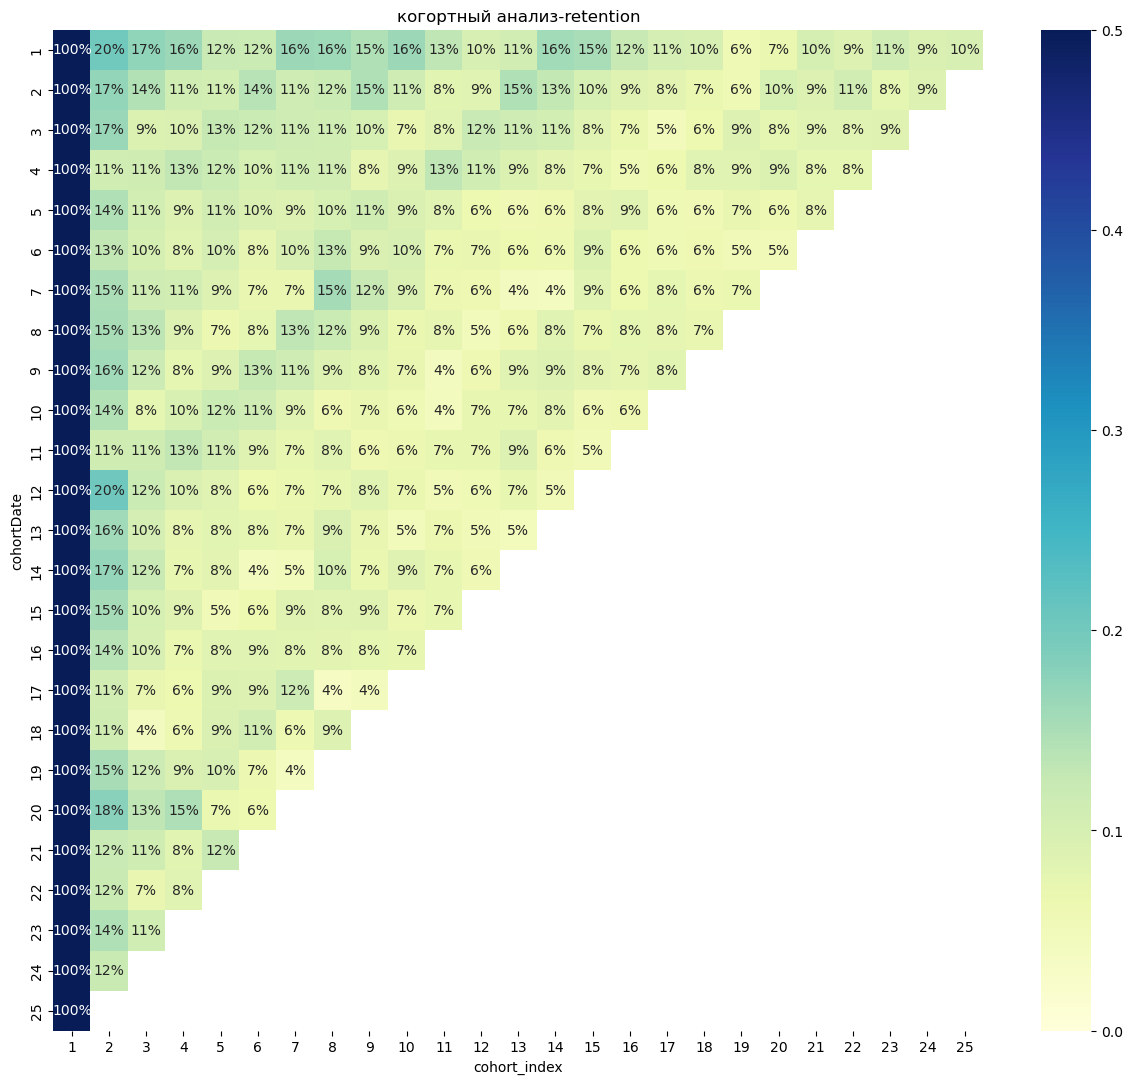

In [679]:
plt.figure(figsize=(15,13))
plt.title('когортный анализ-retention')
sns.heatmap(data=retention,
           annot=True,
           fmt='.0%',
           vmin=0.0,
           vmax=0.5,
           cmap="YlGnBu")
plt.show()

In [680]:
# При анализе периода с 1 до 25 дня: со второго дня и в 25-дневном периоде наблюдается тенденция к уменьшению сумм покупок 

# Вывод: 
# клиенты, в первое посещение магазина спортивных товаров покупают больше (закрывают первичную потребность), 
# далее со временем суммы и кол-во достаточно сильно уменьшаются (далее покупают при необходимости)
# группы с 1 по 15 число покупали больше по сумме и количеству покупок (возможно персональная скидка с 5 - 16 день), 
# далее тенденция на уменьшение, затем стабилизируется и практически не убывает

In [252]:
# Вторая кампания проводилась на жителях города 1 134 и представляла собой баннерную рекламу на билбордах: 
# скидка всем каждое 15-е число месяца (15-й и 45-й день в нашем случае).

In [253]:
df_pers_data_all_purchases

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1
1,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,зеленый,1499,0,37,стол outventure,1,0,1
2,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,бежевый,4799,0,37,набор outventure:,1,0,1
3,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,9199,0,0,роликовые коньки,1,0,0
4,4,0.5072,35.0,0.0,0,1134.0,32.0,3.0,белый,4999,0,0,шлем fila,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780112,177984,0.5072,43.0,1.0,0,1204.0,32.0,0.0,черный,2099,1,47,брюки утепленные,0,0,1
780113,177984,0.5072,43.0,1.0,0,1204.0,32.0,0.0,сливовый,3499,1,55,куртка утепленная,0,0,1
780114,178002,0.4304,50.0,1.0,0,1188.0,32.0,1.0,мультицвет,5999,0,0,кроссовки мужские,0,0,0
780115,178002,0.4304,50.0,1.0,0,1188.0,32.0,1.0,иной,3499,0,57,кеды мужские,0,0,1


In [254]:
df_pers_data_all_purchases['banner_sale'] = df_pers_data_all_purchases.apply(lambda x: 1 if (x.city == 1134 and (x['dt'] == 15 or x['dt'] == 45)) else 0, axis=1)


In [255]:
df_pers_data_all_purchases[df_pers_data_all_purchases['banner_sale'] == 1]

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale
360,98,0.5072,31.0,0.0,0,1134.0,32.0,3.0,зеленый,28500,0,45,sup easy,0,0,1,1
376,101,0.5072,33.0,0.0,0,1134.0,32.0,0.0,небесный,4499,0,15,джемпер флисовый,0,0,1,1
410,105,0.4304,33.0,1.0,0,1134.0,32.0,3.0,иной,29999,0,15,электросамокат hiper,1,0,1,1
470,130,0.5072,63.0,0.0,0,1134.0,32.0,0.0,серый,5999,1,15,ботинки утепленные,0,0,1,1
494,148,0.5072,40.0,0.0,0,1134.0,32.0,2.0,милитари,799,0,15,бейсболка детская,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780027,177760,0.4304,34.0,1.0,0,1134.0,32.0,3.0,желтый,3799,0,15,сумка на,0,0,1,1
780028,177760,0.4304,34.0,1.0,0,1134.0,32.0,3.0,голубой,1999,0,15,фляга salomon,0,0,1,1
780029,177760,0.4304,34.0,1.0,0,1134.0,32.0,3.0,голубой,1399,0,15,фляжка salomon,0,0,1,1
780061,177893,0.5072,43.0,1.0,0,1134.0,32.0,2.0,синий,6999,0,15,комбинезон,0,0,1,1


In [256]:
df_pers_data_all_purchases

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1,0
1,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,зеленый,1499,0,37,стол outventure,1,0,1,0
2,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,бежевый,4799,0,37,набор outventure:,1,0,1,0
3,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,9199,0,0,роликовые коньки,1,0,0,0
4,4,0.5072,35.0,0.0,0,1134.0,32.0,3.0,белый,4999,0,0,шлем fila,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780112,177984,0.5072,43.0,1.0,0,1204.0,32.0,0.0,черный,2099,1,47,брюки утепленные,0,0,1,0
780113,177984,0.5072,43.0,1.0,0,1204.0,32.0,0.0,сливовый,3499,1,55,куртка утепленная,0,0,1,0
780114,178002,0.4304,50.0,1.0,0,1188.0,32.0,1.0,мультицвет,5999,0,0,кроссовки мужские,0,0,0,0
780115,178002,0.4304,50.0,1.0,0,1188.0,32.0,1.0,иной,3499,0,57,кеды мужские,0,0,1,0


## Clustering

#### Clustering (Data Preparation)

In [686]:
# Выясним, на какие кластеры разбивается аудитория и предложим методы работы с каждым кластером. 
# В итоговом анализе должна содержаться информация о том, какие товары предпочитают различные кластеры клиентов и 
# насколько на покупку влияет наличие скидки. 


In [687]:
df_pers_data_all_purchases[:2]


,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1,0
1,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,зеленый,1499,0,37,стол outventure,1,0,1,0


In [688]:
df_cluster_main = df_pers_data_all_purchases.copy()

In [689]:
df_cluster_main.cost.describe()

count    780117.000000
mean       5412.478205
std       10399.469604
min         -30.000000
25%        1499.000000
50%        2999.000000
75%        5599.000000
max      446420.000000
Name: cost, dtype: float64

In [690]:
# проводим кластеризацию только по фактическим покупкам,
# по клиентам, у которых стоимость товара превышает 10 тысяч рублей (крупные покупки)
                
df_cluster_main = df_cluster_main[(df_cluster_main['fact_of_purchase'] == 1) &
                        (df_cluster_main['cost'] > 10000)]

In [691]:
df_cluster_main

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1,0
17,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,черный,11999,0,17,куртка утепленная,1,0,1,0
18,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,мультицвет,23999,0,18,кроссовки мужские,1,0,1,0
38,9,0.5072,48.0,0.0,0,1134.0,32.0,3.0,черный,35999,0,6,электросамокат ninebot,1,1,1,0
56,12,0.4304,44.0,1.0,0,1134.0,32.0,3.0,мультицвет,26999,0,4,велосипед горный,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780081,177923,0.5072,45.0,1.0,0,1134.0,32.0,3.0,салатовый,24099,0,6,комплект: велосипед,0,0,1,0
780082,177923,0.5072,45.0,1.0,0,1134.0,32.0,2.0,иной,13299,0,8,клюшка детская,0,0,1,0
780094,177926,0.5072,33.0,1.0,0,1134.0,32.0,1.0,черный,10799,0,6,костюм спортивный,0,0,1,0
780097,177942,0.4688,23.0,1.0,1,1134.0,32.0,3.0,мультицвет,18499,0,3,мяч футбольный,0,0,1,0


In [692]:
df_cluster_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 81301 entries, 0 to 780099
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        81301 non-null  int64  
 1   personal_coef             81301 non-null  float64
 2   age                       81301 non-null  float64
 3   gender                    81301 non-null  float64
 4   education                 81301 non-null  int64  
 5   city                      81301 non-null  float64
 6   country                   81301 non-null  float64
 7   product_sex_from_product  81301 non-null  float64
 8   colour_main               81301 non-null  object 
 9   cost                      81301 non-null  int64  
 10  base_sale                 81301 non-null  int64  
 11  dt                        81301 non-null  int64  
 12  short_product             81301 non-null  object 
 13  test_group                81301 non-null  int64  
 14  control_gr

In [693]:
df_cluster = df_cluster_main.copy()

#### Clustering (Data Cleaning)

In [694]:
# удаляем неинформативные колонки
# удалим столбец id, fact_of_purchase, country и control_group, в нем не было скидкок 
# (test_group оставляем, в этой группе скидка по первой кампании)

df_cluster = df_cluster.drop(columns=['id', 'control_group', 'country', 'fact_of_purchase'], axis=1)

In [695]:
df_cluster[:3]

,personal_coef,age,gender,education,city,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,banner_sale
0,0.5072,36.0,0.0,0,1201.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0
17,0.4304,52.0,1.0,0,1188.0,1.0,черный,11999,0,17,куртка утепленная,1,0
18,0.4304,52.0,1.0,0,1188.0,1.0,мультицвет,23999,0,18,кроссовки мужские,1,0


In [696]:
df_cluster.colour_main.nunique()

68

In [697]:
df_cluster.short_product.nunique()

508

#### LabelEncoder

In [698]:
# закодируем LabelEncoder категориальный столбец 'colour_main'

df_cluster['colour_main'] = LabelEncoder().fit_transform(df_cluster['colour_main'])

In [699]:
# закодируем LabelEncoder категориальный столбец 'short_product'

df_cluster['short_product'] = LabelEncoder().fit_transform(df_cluster['short_product'])

In [700]:
df_cluster

,personal_coef,age,gender,education,city,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,banner_sale
0,0.5072,36.0,0.0,0,1201.0,0.0,36,13599,1,7,69,1,0
17,0.4304,52.0,1.0,0,1188.0,1.0,65,11999,0,17,198,1,0
18,0.4304,52.0,1.0,0,1188.0,1.0,36,23999,0,18,186,1,0
38,0.5072,48.0,0.0,0,1134.0,3.0,65,35999,0,6,498,1,0
56,0.4304,44.0,1.0,0,1134.0,3.0,36,26999,0,4,69,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
780081,0.5072,45.0,1.0,0,1134.0,3.0,50,24099,0,6,166,0,0
780082,0.5072,45.0,1.0,0,1134.0,2.0,18,13299,0,8,152,0,0
780094,0.5072,33.0,1.0,0,1134.0,1.0,65,10799,0,6,172,0,0
780097,0.4688,23.0,1.0,1,1134.0,3.0,36,18499,0,3,239,0,0


#### StandardScaler

In [701]:
# пронормируем данные

scaler = StandardScaler()
df_cluster_ss = scaler.fit_transform(df_cluster)

In [702]:
df_cluster_ss

array([[ 1.00538562, -0.12613911, -1.72055226, ..., -0.97338874,
         3.43823781, -0.12950245],
       [-0.3126057 ,  1.20307717,  0.58120874, ...,  0.14194636,
         3.43823781, -0.12950245],
       [-0.3126057 ,  1.20307717,  0.58120874, ...,  0.03819426,
         3.43823781, -0.12950245],
       ...,
       [ 1.00538562, -0.37536716,  0.58120874, ..., -0.08284986,
        -0.29084666, -0.12950245],
       [ 0.34638996, -1.20612734,  0.58120874, ...,  0.49643271,
        -0.29084666, -0.12950245],
       [ 0.34638996, -1.20612734,  0.58120874, ...,  0.49643271,
        -0.29084666, -0.12950245]])

In [703]:
# теперь все данные преобразованы в единый масштаб

#### TSNE and clustering

In [704]:
# теперь визуализируем, для этого воспользуемся методом снижения размерности tsne
# размерность итогового пространства надо указать с пом. атрибута n_components 
# применяем tsne к уже пронормированному датасету

In [705]:
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df_cluster_ss)

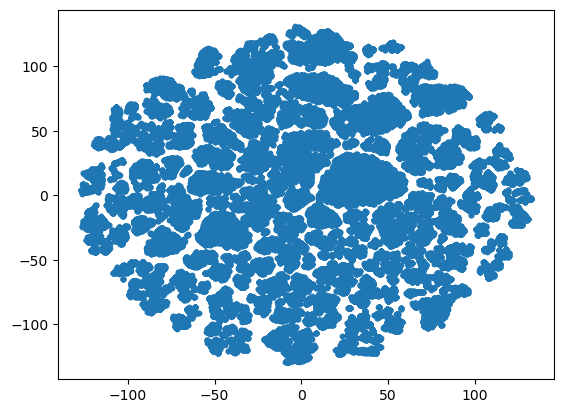

In [706]:
# визуализируем то, что у нас получилось

plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10)

In [246]:
# данные разбились на группы по схожести

#### KMEANS

In [247]:
# в kmeans нужно заранее задавать число кластеров, соответстенно реализуем метод локтя

inertia = []
silhouette = []
N = 10    # максимальное число кластеров, например, 10
for k in range(2, N):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(df_cluster_ss) # применяем метод KMeans с нашим числом кластеров 
    preds = kmeans.predict(df_cluster_ss)
    inertia.append(np.sqrt(kmeans.inertia_))
    silhouette.append(silhouette_score(df_cluster_ss, preds))

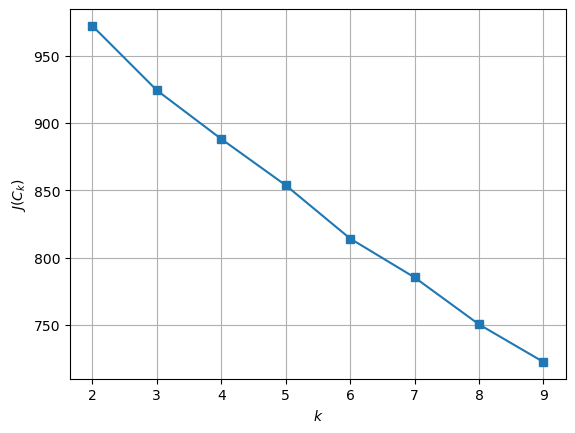

In [248]:
plt.plot(range(2, N), inertia, marker='s'); # нарисуем полученный график
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

In [277]:
# т.к. место значительного перегиба мы не видим, не очень понятно в каком месте выставлять кол-во кластеров

In [278]:
# попробуем рассчитать другую метрику для оценки качества кластеризации - silhouette-score 
# silhouette-score - это еще один способ определить кол-во кластеров

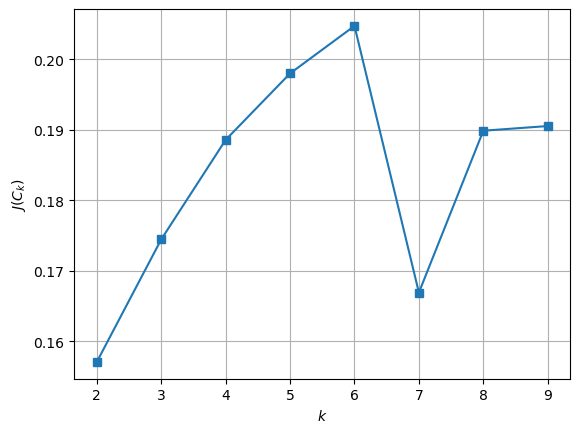

In [281]:
# построим точно такой же график для silhouette-score

plt.plot(range(2, N), silhouette, marker='s');
plt.xlabel('$k$')
plt.grid()
plt.ylabel('$J(C_k)$');

In [282]:
# итак по графику виден значительный пик в районе 6, а также разбиение на 7 кластеров кажется лучшим (преломление)

C:\Users\Julia\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


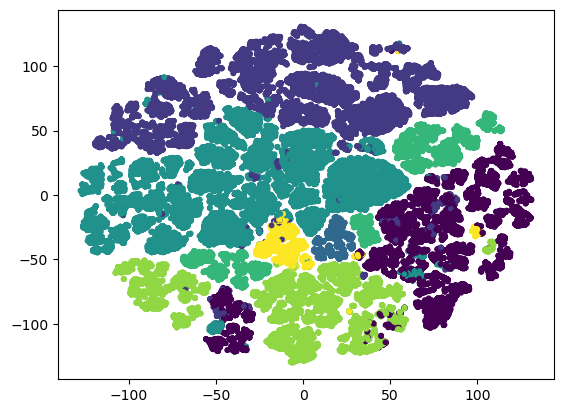

In [283]:
# построим для kmeans

kmeans = KMeans(n_clusters=7, random_state=42).fit(df_cluster_ss)
plt.scatter(df_tsne[:, 0], df_tsne[:, 1], s=10, c=kmeans.labels_)  # построим графики с рекомендуемым числом кластеров 7

In [284]:
# получение меток кластеров

cluster_labels = kmeans.labels_

In [285]:
# добавление меток кластеров в DataFrame

df_cluster_main['cluster'] = cluster_labels

In [286]:
# DataFrame с кластерными метками

df_cluster_main

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale,cluster
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1,0,4
17,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,черный,11999,0,17,куртка утепленная,1,0,1,0,4
18,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,мультицвет,23999,0,18,кроссовки мужские,1,0,1,0,4
38,9,0.5072,48.0,0.0,0,1134.0,32.0,3.0,черный,35999,0,6,электросамокат ninebot,1,1,1,0,4
56,12,0.4304,44.0,1.0,0,1134.0,32.0,3.0,мультицвет,26999,0,4,велосипед горный,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780081,177923,0.5072,45.0,1.0,0,1134.0,32.0,3.0,салатовый,24099,0,6,комплект: велосипед,0,0,1,0,1
780082,177923,0.5072,45.0,1.0,0,1134.0,32.0,2.0,иной,13299,0,8,клюшка детская,0,0,1,0,3
780094,177926,0.5072,33.0,1.0,0,1134.0,32.0,1.0,черный,10799,0,6,костюм спортивный,0,0,1,0,3
780097,177942,0.4688,23.0,1.0,1,1134.0,32.0,3.0,мультицвет,18499,0,3,мяч футбольный,0,0,1,0,0


In [292]:
df_cluster_main.cluster.value_counts()

cluster
3    26483
1    20345
0    13499
5    11464
4     6025
6     2144
2     1341
Name: count, dtype: int64

#### Clustering (Results)

In [293]:
# изучим полученные кластеры (от меньшего количества к большему)

#cluster
# 3    26483
# 1    20345
# 0    13499
# 5    11464
# 4     6025
# 6     2144
# 2     1341


##### cluster_2

In [297]:
cluster_2 = df_cluster_main[df_cluster_main['cluster'] == 2]
cluster_2

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale,cluster
360,98,0.5072,31.0,0.0,0,1134.0,32.0,3.0,зеленый,28500,0,45,sup easy,0,0,1,1,2
410,105,0.4304,33.0,1.0,0,1134.0,32.0,3.0,иной,29999,0,15,электросамокат hiper,1,0,1,1,2
839,287,0.4304,54.0,1.0,0,1134.0,32.0,1.0,черный,10799,0,45,костюм спортивный,0,0,1,1,2
1088,361,0.5072,46.0,0.0,0,1134.0,32.0,0.0,черный,33999,0,15,велосипед горный,0,0,1,1,2
1760,560,0.4304,50.0,1.0,0,1134.0,32.0,3.0,иной,12999,0,15,велосипед складной,0,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779394,176695,0.4304,41.0,1.0,0,1134.0,32.0,1.0,серый,10299,0,15,спортивный костюм,0,0,1,1,2
779506,176816,0.2672,17.0,1.0,1,1134.0,32.0,1.0,мультицвет,27999,0,15,ботинки мужские,0,1,1,1,2
779507,176816,0.2672,17.0,1.0,1,1134.0,32.0,3.0,оранжевый,92499,0,15,велосипед горный,0,1,1,1,2
779509,176816,0.2672,17.0,1.0,1,1134.0,32.0,1.0,мультицвет,16899,0,15,кроссовки мужские,0,1,1,1,2


In [298]:
# банерная реклама

cluster_2.banner_sale.value_counts()

banner_sale
1    1341
Name: count, dtype: int64

In [299]:
# скидка всем каждое 15-е число месяца (15-й и 45-й день в нашем случае)

cluster_2.dt.value_counts()

dt
15    841
45    500
Name: count, dtype: int64

In [301]:
# кампания проводилась для жителей города 1134

cluster_2.city.unique()

array([1134.])

In [302]:
cluster_2.short_product.value_counts().head(10)

short_product
кроссовки мужские      263
велосипед горный       126
кроссовки женские       87
кеды мужские            78
ботинки мужские         50
полуботинки мужские     39
комплект: велосипед     29
куртка мембранная       28
ботинки утепленные      25
куртка утепленная       19
Name: count, dtype: int64

In [304]:
print(f' Покупки на сумму: {cluster_2.cost.sum()}')

 Покупки на сумму: 32091547


In [761]:
# cluster_2 полностью состоит из клиентов города 1134, которые купили товары по второй рекламной кампании, 
# которая проводилась на жителях города 1 134 и представляла собой баннерную рекламу на билбордах: 
# скидка всем каждое 15-е число месяца (15-й и 45-й день в нашем случае)

##### cluster_6

In [306]:
cluster_6 = df_cluster_main[df_cluster_main['cluster'] == 6]
cluster_6

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale,cluster
1171,390,0.4304,38.0,1.0,0,33.0,32.0,1.0,серый,57999,0,15,куртка мембранная,0,0,1,0,6
1172,390,0.4304,38.0,1.0,0,33.0,32.0,1.0,мультицвет,13599,0,20,кроссовки мужские,0,0,1,0,6
1439,494,0.4304,53.0,1.0,0,9.0,32.0,3.0,черный,13599,0,8,рюкзак salomon,0,0,1,0,6
1518,508,0.5072,37.0,0.0,0,73.0,32.0,3.0,черный,12999,0,15,велосипед складной,0,0,1,0,6
1520,508,0.5072,37.0,0.0,0,73.0,32.0,3.0,иной,12999,0,52,велосипед складной,0,0,1,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779551,176865,0.4304,33.0,0.0,0,66.0,32.0,1.0,мультицвет,13499,0,47,кеды мужские,0,0,1,0,6
779882,177529,0.5072,51.0,0.0,0,182.0,32.0,0.0,черный,15999,0,13,полуботинки женские,0,1,1,0,6
779885,177529,0.5072,51.0,0.0,0,182.0,32.0,0.0,иной,15999,0,16,полуботинки женские,0,1,1,0,6
779886,177529,0.5072,51.0,0.0,0,182.0,32.0,0.0,иной,13999,0,16,сандалии женские,0,1,1,0,6


In [310]:
# cluster_6 состоит из городов от 1 до 144, возможно это ближайшие регионы

cluster_6.city.value_counts().unique()

array([144, 135, 134,  98,  83,  55,  50,  49,  44,  35,  33,  30,  28,
        26,  25,  24,  21,  20,  19,  18,  17,  16,  15,  14,  13,  12,
        11,  10,   9,   8,   7,   6,   5,   4,   3,   2,   1], dtype=int64)

In [315]:
# наблюдается тенденция утепленных товаров

cluster_6.short_product.value_counts().head(10)

short_product
кроссовки мужские      337
велосипед горный       232
кроссовки женские      149
кеды мужские            90
полуботинки мужские     60
ботинки мужские         55
велосипед               45
куртка утепленная       44
ботинки утепленные      41
комплект: велосипед     41
Name: count, dtype: int64

In [316]:
print(f' Покупки на сумму: {cluster_6.cost.sum()}')

 Покупки на сумму: 51476406


In [317]:
# cluster_6 полностью состоит из клиентов  городов с 1 до 144 (возможно северные или горные регионы, 
# т.к. есть тенденция утепленных товаров), покупали почти без скидок и кампаний

##### cluster_4

In [343]:
cluster_4 = df_cluster_main[df_cluster_main['cluster'] == 4]
cluster_4

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale,cluster
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1,0,4
17,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,черный,11999,0,17,куртка утепленная,1,0,1,0,4
18,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,мультицвет,23999,0,18,кроссовки мужские,1,0,1,0,4
38,9,0.5072,48.0,0.0,0,1134.0,32.0,3.0,черный,35999,0,6,электросамокат ninebot,1,1,1,0,4
58,13,0.5072,40.0,0.0,0,1155.0,32.0,1.0,мультицвет,33999,0,3,бутсы мужские,1,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779143,176283,0.5072,46.0,1.0,0,1209.0,32.0,2.0,мультицвет,11199,0,42,ботинки,1,0,1,0,4
779258,176573,0.5072,43.0,1.0,0,1203.0,32.0,0.0,иной,12799,0,4,кроссовки женские,1,0,1,0,4
779266,176573,0.5072,43.0,1.0,0,1203.0,32.0,1.0,иной,21999,0,22,кроссовки мужские,1,0,1,0,4
780071,177906,0.2672,15.0,1.0,1,1156.0,32.0,3.0,черный,18490,0,21,sup надувной,1,0,1,0,4


In [346]:
# в кластере все клиенты с персональной скидкой через email-рассылку (первая кампания)

cluster_4.test_group.value_counts()

test_group
1    6025
Name: count, dtype: int64

In [347]:
cluster_4.product_sex_from_product.value_counts()

product_sex_from_product
1.0    2570
3.0    2262
0.0    1003
2.0     190
Name: count, dtype: int64

In [353]:
cluster_4.short_product.value_counts().head(10)

short_product
кроссовки мужские      1089
велосипед горный        683
кроссовки женские       345
ботинки мужские         174
полуботинки мужские     170
кеды мужские            160
куртка утепленная       156
комплект: велосипед     137
куртка мембранная       119
ботинки утепленные      104
Name: count, dtype: int64

In [351]:
print(f' Покупки на сумму: {cluster_4.cost.sum()}')

 Покупки на сумму: 139043784


In [354]:
# cluster_4 полностью состоит из клиентов, которым была направлена персональная скидка на mail
# клиенты предпочитают много обуви и велосипеды

##### cluster_5

In [362]:
cluster_5 = df_cluster_main[df_cluster_main['cluster'] == 5]
cluster_5

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale,cluster
113,26,0.4304,44.0,1.0,0,1203.0,32.0,0.0,мультицвет,19999,1,49,велосипед горный,0,0,1,0,5
369,100,0.5584,30.0,0.0,1,1157.0,32.0,1.0,черный,10709,1,30,куртка мужская,0,0,1,0,5
370,100,0.5584,30.0,0.0,1,1157.0,32.0,0.0,мультицвет,16799,1,30,анорак женский,0,0,1,0,5
599,199,0.4304,34.0,1.0,0,1201.0,32.0,1.0,мультицвет,11829,1,52,кроссовки мужские,0,0,1,0,5
615,201,0.4688,21.0,1.0,1,1180.0,32.0,1.0,мультицвет,11249,1,43,кеды мужские,0,0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779827,177486,0.4304,37.0,1.0,0,1134.0,32.0,3.0,иной,12990,1,42,лодка пвх,0,0,1,0,5
779828,177486,0.4304,37.0,1.0,0,1134.0,32.0,3.0,черный,42299,1,56,велосипед горный,0,0,1,0,5
779970,177634,0.5072,40.0,1.0,0,1188.0,32.0,1.0,мультицвет,13159,1,8,кроссовки мужские,0,0,1,0,5
779989,177652,0.5072,35.0,1.0,0,1175.0,32.0,2.0,серый,21599,1,56,велосипед,0,0,1,0,5


In [375]:
# кластер полностью из клиентов с base_sale (наличие скидки на момент покупки)

cluster_5.base_sale.value_counts()

base_sale
1    11464
Name: count, dtype: int64

In [377]:
# более чем на 70% кластер состоит из мужчин

cluster_5.gender.value_counts()

gender
1.0    8486
0.0    2978
Name: count, dtype: int64

In [378]:
cluster_5.short_product.value_counts().head(10)

short_product
кроссовки мужские      2533
велосипед горный       1047
кроссовки женские       992
ботинки мужские         553
полуботинки мужские     484
куртка мембранная       474
кеды мужские            315
палатка 4-местная       259
полуботинки женские     253
куртка утепленная       247
Name: count, dtype: int64

In [379]:
print(f' Покупки на сумму: {cluster_5.cost.sum()}')

 Покупки на сумму: 197520990


In [779]:
# cluster_5 полностью состоит из клиентов с base_sale (наличие скидки на момент покупки) 
# более чем на 70% кластер состоит из мужчин
# клиенты предпочитают много обуви и велосипеды

##### cluster_0

In [386]:
cluster_0 = df_cluster_main[df_cluster_main['cluster'] == 0]
cluster_0

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale,cluster
128,39,0.4688,21.0,1.0,1,1188.0,32.0,1.0,мультицвет,19599,0,30,полуботинки мужские,0,1,1,0,0
135,40,0.4688,35.0,1.0,1,1188.0,32.0,0.0,мультицвет,17999,0,5,кроссовки женские,0,0,1,0,0
136,40,0.4688,35.0,1.0,1,1188.0,32.0,1.0,белый,25999,0,38,куртка софтшелл,0,0,1,0,0
137,40,0.4688,35.0,1.0,1,1188.0,32.0,0.0,мультицвет,14999,0,41,кроссовки женские,0,0,1,0,0
139,40,0.4688,35.0,1.0,1,1188.0,32.0,0.0,иной,14279,0,46,кроссовки женские,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779805,177469,0.2576,15.0,1.0,0,1158.0,32.0,1.0,мультицвет,19599,0,25,кроссовки мужские,0,0,1,0,0
779806,177469,0.2576,15.0,1.0,0,1158.0,32.0,1.0,иной,18399,0,29,ветровка мужская,0,0,1,0,0
779811,177469,0.2576,15.0,1.0,0,1158.0,32.0,1.0,мультицвет,19599,0,33,кроссовки мужские,0,0,1,0,0
780097,177942,0.4688,23.0,1.0,1,1134.0,32.0,3.0,мультицвет,18499,0,3,мяч футбольный,0,0,1,0,0


In [387]:
cluster_0.gender.value_counts()

gender
1.0    11054
0.0     2445
Name: count, dtype: int64

In [388]:
cluster_0.education.value_counts()

education
1    12937
0      562
Name: count, dtype: int64

In [391]:
cluster_0.product_sex_from_product.value_counts()

product_sex_from_product
3.0    5844
1.0    5543
0.0    1703
2.0     409
Name: count, dtype: int64

In [409]:
# количество покупок (по убыванию)

cluster_0.short_product.value_counts().head(10)

short_product
кроссовки мужские      2371
велосипед горный       1906
кеды мужские           1088
кроссовки женские       626
комплект: велосипед     434
ботинки мужские         243
полуботинки мужские     243
куртка утепленная       226
бутсы мужские           204
куртка мембранная       186
Name: count, dtype: int64

In [449]:
# гуппировка по продукту, сумма покупок (по убыванию)

cluster_0.groupby('short_product', as_index=False).agg(sum_purchases=('cost', 'sum')).sort_values('sum_purchases', ascending=False).head(10)

,short_product,sum_purchases
58,велосипед горный,66581666
152,кроссовки мужские,39639770
120,кеды мужские,19102337
133,комплект: велосипед,11533066
151,кроссовки женские,9855365
64,велосипед шоссейный,9661115
59,велосипед городской,6743072
25,беговая дорожка,6676455
159,куртка мембранная,6420654
36,ботинки мужские,4838597


In [405]:
print(f' Покупки на сумму: {cluster_0.cost.sum()}')

 Покупки на сумму: 330098019


In [786]:
# cluster_0 более чем на 80% состоит из мужчин, преимущественно с высшим образованием, 
# в кластере много товаров для мужчин или товаров без конкретной гендерной принадлежности
# тенденция: кроссовки и велосипеды

##### cluster_1

In [414]:
cluster_1 = df_cluster_main[df_cluster_main['cluster'] == 1]
cluster_1

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale,cluster
56,12,0.4304,44.0,1.0,0,1134.0,32.0,3.0,мультицвет,26999,0,4,велосипед горный,0,0,1,0,1
57,12,0.4304,44.0,1.0,0,1134.0,32.0,3.0,мультицвет,26999,0,51,велосипед горный,0,0,1,0,1
71,17,0.5072,49.0,0.0,0,1198.0,32.0,3.0,мультицвет,18999,0,25,велосипед горный,0,0,1,0,1
141,41,0.4304,34.0,1.0,0,1134.0,32.0,3.0,мультицвет,24999,0,9,велосипед горный,0,0,1,0,1
143,41,0.4304,34.0,1.0,0,1134.0,32.0,3.0,мультицвет,25099,0,9,комплект: велосипед,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779845,177511,0.4304,46.0,1.0,0,1189.0,32.0,3.0,мультицвет,29799,0,2,комплект: велосипед,0,0,1,0,1
779874,177518,0.5072,40.0,1.0,0,1134.0,32.0,3.0,серый,34999,0,9,велосипед городской,0,0,1,0,1
779933,177594,0.4304,39.0,1.0,0,1134.0,32.0,3.0,матовый,77200,0,1,велосипед шоссейный,0,0,1,0,1
779986,177652,0.5072,35.0,1.0,0,1175.0,32.0,3.0,мультицвет,26999,0,9,велосипед горный,0,0,1,0,1


In [421]:
cluster_1.gender.value_counts()

gender
1.0    15508
0.0     4837
Name: count, dtype: int64

In [422]:
cluster_1.product_sex_from_product.value_counts()

product_sex_from_product
3.0    19976
2.0      266
1.0      103
Name: count, dtype: int64

In [423]:
cluster_1.education.value_counts()

education
0    19925
1      420
Name: count, dtype: int64

In [424]:
cluster_1.short_product.value_counts().head(30)

short_product
велосипед горный           4297
палатка 4-местная          1091
комплект: велосипед         694
велосипед городской         543
велосипед складной          530
тент outventure             501
палатка 2-местная           479
беговая дорожка             454
sup надувной                445
велосипед шоссейный         385
кроссовки new               312
электросамокат ninebot      287
ракетка                     286
спальный мешок              280
палатка 3-местная           262
беговые лыжи                248
эллиптический тренажер      228
теннисный стол              220
роликовые коньки            211
доска sup                   202
велотренажер магнитный      183
тренажер эллиптический      181
мешок спальный              178
велосипед bmx               177
коньки хоккейные            171
велосипед stark'23          167
рюкзак tatonka              167
ботинки                     162
велосипед гравийный         162
электровелосипед горный     160
Name: count, dtype: int64

In [429]:
# гуппировка по продукту, сумма покупок (по убыванию)

cluster_1.groupby('short_product', as_index=False).agg(sum_purchases=('cost', 'sum')).sort_values('sum_purchases', ascending=False).head(20)

,short_product,sum_purchases
49,велосипед горный,218955608
55,велосипед шоссейный,37637307
29,беговая дорожка,22622646
178,палатка 2-местная,22007321
50,велосипед городской,21199192
109,комплект: велосипед,19718106
182,палатка 4-местная,17050219
84,доска sup,12904200
355,электросамокат ninebot,12363470
14,sup надувной,12324933


In [425]:
print(f' Покупки на сумму: {cluster_1.cost.sum()}')

 Покупки на сумму: 757336730


In [793]:
# cluster_1 клиенты со средним образованием
# кластер почти полностью состоит из товаров без конкретной гендерной принадлежности
# предпочтения: велосипеды, беговые дорожки, палатки, электросамокаты, тренажеры, эхолот (рыбалка)

##### cluster_3

In [430]:
cluster_3 = df_cluster_main[df_cluster_main['cluster'] == 3]
cluster_3

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale,cluster
215,59,0.4304,39.0,1.0,0,1203.0,32.0,1.0,иной,10849,0,27,кроссовки мужские,0,0,1,0,3
218,59,0.4304,39.0,1.0,0,1203.0,32.0,1.0,красный,12499,0,41,куртка утепленная,0,0,1,0,3
223,60,0.4304,35.0,1.0,0,1134.0,32.0,1.0,мультицвет,13499,0,2,кеды мужские,0,0,1,0,3
224,60,0.4304,35.0,1.0,0,1134.0,32.0,2.0,иной,13999,0,2,кроссовки,0,0,1,0,3
358,98,0.5072,31.0,0.0,0,1134.0,32.0,1.0,коричневый,11999,0,3,ботинки мужские,0,0,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779979,177641,0.5072,45.0,1.0,0,1188.0,32.0,1.0,черный,11199,0,5,кроссовки мужские,0,0,1,0,3
780044,177826,0.4304,25.0,1.0,0,1177.0,32.0,1.0,мультицвет,12499,0,7,кроссовки мужские,0,0,1,0,3
780063,177893,0.5072,43.0,1.0,0,1134.0,32.0,1.0,иной,10499,0,47,спортивный костюм,0,0,1,0,3
780082,177923,0.5072,45.0,1.0,0,1134.0,32.0,2.0,иной,13299,0,8,клюшка детская,0,0,1,0,3


In [432]:
cluster_3.gender.value_counts()

gender
1.0    18757
0.0     7726
Name: count, dtype: int64

In [433]:
cluster_3.education.value_counts()

education
0    26003
1      480
Name: count, dtype: int64

In [435]:
cluster_3.product_sex_from_product.value_counts()

product_sex_from_product
1.0    17475
0.0     7491
2.0     1517
Name: count, dtype: int64

In [444]:
cluster_3.short_product.value_counts().head(10)

short_product
кроссовки мужские      7780
кроссовки женские      2664
полуботинки мужские    1364
ботинки мужские        1313
кеды мужские           1019
велосипед горный       1007
куртка утепленная       978
велосипед               904
куртка мембранная       667
ботинки утепленные      584
Name: count, dtype: int64

In [445]:
# гуппировка по продукту, сумма покупок (по убыванию)

cluster_3.groupby('short_product', as_index=False).agg(sum_purchases=('cost', 'sum')).sort_values('sum_purchases', ascending=False).head(10)

,short_product,sum_purchases
68,кроссовки мужские,128663425
67,кроссовки женские,42040981
22,велосипед горный,27298646
9,ботинки мужские,25487697
97,полуботинки мужские,19288596
75,куртка мембранная,18524693
79,куртка утепленная,17915172
51,кеды мужские,17870411
21,велосипед,14864806
103,пуховик мужской,10803758


In [438]:
print(f' Покупки на сумму: {cluster_3.cost.sum()}')

 Покупки на сумму: 460014886


In [ ]:
# cluster_3 клиенты со средним образованием, около 70% мужчины
# в кластере полностью отсутствуют товары без конкретной гендерной принадлежности, 
# т.е. в кластере покупки товаров для мужчин, женщин и детей
# кластер самый объемный и в большой степени состоит из обуви и одежды

## Multi class classification

In [1098]:
# Построение модели склонности клиента к покупке определённого товара

In [1099]:
# Интересует информация о жителях страны 32 города 1 188: именно на них планируется запуск новой маркетинговой кампании. 
# Построим модель склонности клиента к покупке определённого товара при коммуникации, 
# основанную на данных о профилях клиентов, данных товаров и данных о прошлых маркетинговых кампаниях.

#### Multi class classification (Data Preparation)

In [257]:
df_new_company = df_pers_data_all_purchases.copy()

In [258]:
df_new_company.head()

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale
0,0,0.5072,36.0,0.0,0,1201.0,32.0,0.0,мультицвет,13599,1,7,велосипед горный,1,0,1,0
1,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,зеленый,1499,0,37,стол outventure,1,0,1,0
2,0,0.5072,36.0,0.0,0,1201.0,32.0,3.0,бежевый,4799,0,37,набор outventure:,1,0,1,0
3,4,0.5072,35.0,0.0,0,1134.0,32.0,2.0,мультицвет,9199,0,0,роликовые коньки,1,0,0,0
4,4,0.5072,35.0,0.0,0,1134.0,32.0,3.0,белый,4999,0,0,шлем fila,1,0,0,0


In [259]:
df_1188 = df_new_company[df_new_company['city'] == 1188]
df_1188

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale
10,6,0.4304,52.0,1.0,0,1188.0,32.0,2.0,мультицвет,4999,0,1,кроссовки,1,0,1,0
11,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,черный,4799,1,3,кеды мужские,1,0,1,0
12,6,0.4304,52.0,1.0,0,1188.0,32.0,1.0,синий,999,0,8,футболка мужская,1,0,1,0
13,6,0.4304,52.0,1.0,0,1188.0,32.0,2.0,синий,1119,1,11,бейсболка детская,1,0,1,0
14,6,0.4304,52.0,1.0,0,1188.0,32.0,2.0,мультицвет,299,0,11,носки детские,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779979,177641,0.5072,45.0,1.0,0,1188.0,32.0,1.0,черный,11199,0,5,кроссовки мужские,0,0,1,0
779980,177641,0.5072,45.0,1.0,0,1188.0,32.0,0.0,иной,2999,0,51,брюки женские,0,0,1,0
780114,178002,0.4304,50.0,1.0,0,1188.0,32.0,1.0,мультицвет,5999,0,0,кроссовки мужские,0,0,0,0
780115,178002,0.4304,50.0,1.0,0,1188.0,32.0,1.0,иной,3499,0,57,кеды мужские,0,0,1,0


In [260]:
df_1188.country.unique()

array([32.])

In [261]:
df_1188.city.unique()

array([1188.])

In [262]:
# в этой выборке скидки banner_sale у клиентов нет

df_1188.banner_sale.value_counts()

banner_sale
0    88889
Name: count, dtype: int64

In [263]:
df_1188[df_1188['age'] < 16].shape

(1784, 17)

In [264]:
# для точности предсказания модели удалим записи с клиентами < 16 лет (1784 записи)

In [265]:
df_1188 = df_1188[df_1188['age'] >= 16]

In [266]:
df_1188[df_1188['age'] < 16]

,id,personal_coef,age,gender,education,city,country,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,control_group,fact_of_purchase,banner_sale


In [267]:
df_1188.shape

(87105, 17)

In [268]:
# удаляем неинформативные колонки

df_1188 = df_1188.drop(columns=['banner_sale', 'control_group', 'country', 'city'], axis=1)

In [269]:
df_1188.head(5)

,id,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,fact_of_purchase
10,6,0.4304,52.0,1.0,0,2.0,мультицвет,4999,0,1,кроссовки,1,1
11,6,0.4304,52.0,1.0,0,1.0,черный,4799,1,3,кеды мужские,1,1
12,6,0.4304,52.0,1.0,0,1.0,синий,999,0,8,футболка мужская,1,1
13,6,0.4304,52.0,1.0,0,2.0,синий,1119,1,11,бейсболка детская,1,1
14,6,0.4304,52.0,1.0,0,2.0,мультицвет,299,0,11,носки детские,1,1


In [270]:
df_1188.shape

(87105, 13)

#### Multi class classification (Feature engineering)

In [271]:
# разделение по cost (стоимость товара)

# low      - cost <= 2000 - i_am_just_looking
# standard - cost > 2000 or cost <= 10000 - i_know_what_i_want
# premium  - cost > 10000 or cost <= 30000 - real_sportsman
# private  - cost > 30000 - magistr_of_sport

df_1188['status_of_product'] = df_1188.apply(lambda x: 'i_am_just_looking' if (x.cost <= 2000) or (x['dt'] == 0) else
                                             ('i_know_what_i_want' if x.cost > 2000 and x.cost <= 10000 else
                                             ('real_sportsman' if x.cost > 10000 and x.cost <= 30000 else 'magistr_of_sport')), axis=1)
                                              

In [272]:
df_1188.head(5)

,id,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,fact_of_purchase,status_of_product
10,6,0.4304,52.0,1.0,0,2.0,мультицвет,4999,0,1,кроссовки,1,1,i_know_what_i_want
11,6,0.4304,52.0,1.0,0,1.0,черный,4799,1,3,кеды мужские,1,1,i_know_what_i_want
12,6,0.4304,52.0,1.0,0,1.0,синий,999,0,8,футболка мужская,1,1,i_am_just_looking
13,6,0.4304,52.0,1.0,0,2.0,синий,1119,1,11,бейсболка детская,1,1,i_am_just_looking
14,6,0.4304,52.0,1.0,0,2.0,мультицвет,299,0,11,носки детские,1,1,i_am_just_looking


In [273]:
df_1188.status_of_product.value_counts(dropna=False)

status_of_product
i_know_what_i_want    45169
i_am_just_looking     32779
real_sportsman         7750
magistr_of_sport       1407
Name: count, dtype: int64

In [277]:
df_1188[df_1188['status_of_product'] == 'magistr_of_sport']['short_product'].tolist()[:20]

["велосипед stark'23",
 "велосипед stark'22",
 'велосипед шоссейный',
 'велосипед шоссейный',
 'велосипед шоссейный',
 'доска sup',
 'велосипед горный',
 'велосипед горный',
 'комплект лыжный',
 'электровелосипед eltreco',
 'велосипед городской',
 'велосипед горный',
 'ботинки горнолыжные',
 'кроссовки мужские',
 'велосипед горный',
 'кроссовки мужские',
 'электровелосипед eltreco',
 'байдарка тритон',
 'байдарка тритон',
 'велосипед городской']

In [278]:
# создаем новый столбец "department"
# создаем регулярное выражение для проверки нескольких подстрок

pattern1 = r'рубашка|брюки|футболка|лонгслив|велосипедки|носки|бриджи|джемпер|шорты|куртка|ветровка|толстовка|лиф|юбка-шорты|худи|топ|туника|бейсболка|панама|купальник|свитшот|пуховик|костюм|поло|платье|легинсы|плавки|майка|юбка|трусы|жилет|рашгард|тайтсы|термобелье'
pattern2 = r'сандалии|кроссовки|шлепанцы|кеды|полуботинки|ботинки|бутсы|слипоны|сабо|сапоги|балетки'
pattern3 = r'велосипед|электросамокат|электровелосипед|велостанок|самокат|роликовые коньки'
pattern4 = r'сноуборд|лыжи|дорожка|велостанок|тренажер|ледянка'
pattern5 = r'байдарка|доска|sup|эхолот|гидрокостюм'
pattern6 = r'палатка|спальный мешок|спальный|батут|кресло кемпинговое|тент'
pattern7 = r'очки|сумка|рюкзак|ракетка|мяч|шапочка|коврик самонадувающийся|матрас надувной|набор|мешок|коврик'

df_1188['department'] = df_1188['short_product'].apply(lambda x: 'clothes' if pd.Series(x).str.contains(pattern1).any() else 
                                                       ('shoes' if pd.Series(x).str.contains(pattern2).any() else
                                                       'faster_than_walking' if pd.Series(x).str.contains(pattern3).any() else
                                                        'runners' if pd.Series(x).str.contains(pattern4).any() else 
                                                        'water_equipment' if pd.Series(x).str.contains(pattern5).any() else
                                                        'camping' if pd.Series(x).str.contains(pattern6).any() else 
                                                        'take_me_with_you' if pd.Series(x).str.contains(pattern7).any() else 'other'))

In [279]:
# все отделы заполнены

df_1188['department'].value_counts(dropna=False)

department
clothes                36116
shoes                  28045
other                  10417
take_me_with_you        6919
faster_than_walking     3244
camping                 1826
runners                  309
water_equipment          229
Name: count, dtype: int64

In [280]:
df_1188.head(5)

,id,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,fact_of_purchase,status_of_product,department
10,6,0.4304,52.0,1.0,0,2.0,мультицвет,4999,0,1,кроссовки,1,1,i_know_what_i_want,shoes
11,6,0.4304,52.0,1.0,0,1.0,черный,4799,1,3,кеды мужские,1,1,i_know_what_i_want,shoes
12,6,0.4304,52.0,1.0,0,1.0,синий,999,0,8,футболка мужская,1,1,i_am_just_looking,clothes
13,6,0.4304,52.0,1.0,0,2.0,синий,1119,1,11,бейсболка детская,1,1,i_am_just_looking,clothes
14,6,0.4304,52.0,1.0,0,2.0,мультицвет,299,0,11,носки детские,1,1,i_am_just_looking,clothes


In [1122]:
# определяем таргет (целевая переменная)
# т.к. у нас в наличии большинство клиентов купили товар (высокая конверсия в покупку), будем выявлять
# склонность клиента к покупке определенного товара (многоклассовая классификация):

# athletic_girls - женщины, знают, что хотят (стоимость продукта от 2000 до 10000), в основном одежда и обувь

# sport_guys - мужчины, знают, что хотят (стоимость продукта от 2000 до 10000), много одежды и обуви, 
# остальное из разных категорий

# beginners - мужчины и женщины поровну, много товаров из категории гендерный признак товара - "иное",
# категория продукта - 'я_только_посмотреть - это малые покупки по стоимости менее 2000 (cost) или дата покупки ноль (посмотрел, но пока не купил)

# sport_VIP - VIP сегмент, мужчины и женщины, очень спортивная группа по различным направлениям спорта, дорогие покупки
# эта группа 'уверенный_спортсмен' покупки стоимостью от 10000 и 'магистр_спорта' покупки стоимостью от 30000

In [1123]:
df_1188['target'] = df_1188.apply(
    lambda x: 'athletic_girls' if (x.gender == 0) and (x.status_of_product == 'i_know_what_i_want') else
              ('sport_guys' if (x.gender == 1) and (x.status_of_product == 'i_know_what_i_want') else
              'beginners' if (x.status_of_product == 'i_am_just_looking') else
              'sport_VIP' if (x.status_of_product == 'real_sportsman') or (x.status_of_product == 'magistr_of_sport') else 'other'), 
    axis=1
)

In [1124]:
df_1188

,id,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,fact_of_purchase,status_of_product,department,target
10,6,0.4304,52.0,1.0,0,2.0,мультицвет,4999,0,1,кроссовки,1,1,i_know_what_i_want,shoes,sport_guys
11,6,0.4304,52.0,1.0,0,1.0,черный,4799,1,3,кеды мужские,1,1,i_know_what_i_want,shoes,sport_guys
12,6,0.4304,52.0,1.0,0,1.0,синий,999,0,8,футболка мужская,1,1,i_am_just_looking,clothes,beginners
13,6,0.4304,52.0,1.0,0,2.0,синий,1119,1,11,бейсболка детская,1,1,i_am_just_looking,clothes,beginners
14,6,0.4304,52.0,1.0,0,2.0,мультицвет,299,0,11,носки детские,1,1,i_am_just_looking,clothes,beginners
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
779979,177641,0.5072,45.0,1.0,0,1.0,черный,11199,0,5,кроссовки мужские,0,1,real_sportsman,shoes,sport_VIP
779980,177641,0.5072,45.0,1.0,0,0.0,иной,2999,0,51,брюки женские,0,1,i_know_what_i_want,clothes,sport_guys
780114,178002,0.4304,50.0,1.0,0,1.0,мультицвет,5999,0,0,кроссовки мужские,0,0,i_am_just_looking,shoes,beginners
780115,178002,0.4304,50.0,1.0,0,1.0,иной,3499,0,57,кеды мужские,0,1,i_know_what_i_want,shoes,sport_guys


In [1125]:
# проверим какое распределение классов у целевой переменной (target)
# кол-во отличается, DataFrame не очень сбалансирован

df_1188.target.value_counts(dropna=False)

target
beginners         32779
sport_guys        26990
athletic_girls    18179
sport_VIP          9157
Name: count, dtype: int64

In [1126]:
# таргет полностью заполнен

df_1188[df_1188['target'] == 'other']

,id,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,fact_of_purchase,status_of_product,department,target


In [1127]:
df_1188[:10]

,id,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,fact_of_purchase,status_of_product,department,target
10,6,0.4304,52.0,1.0,0,2.0,мультицвет,4999,0,1,кроссовки,1,1,i_know_what_i_want,shoes,sport_guys
11,6,0.4304,52.0,1.0,0,1.0,черный,4799,1,3,кеды мужские,1,1,i_know_what_i_want,shoes,sport_guys
12,6,0.4304,52.0,1.0,0,1.0,синий,999,0,8,футболка мужская,1,1,i_am_just_looking,clothes,beginners
13,6,0.4304,52.0,1.0,0,2.0,синий,1119,1,11,бейсболка детская,1,1,i_am_just_looking,clothes,beginners
14,6,0.4304,52.0,1.0,0,2.0,мультицвет,299,0,11,носки детские,1,1,i_am_just_looking,clothes,beginners
15,6,0.4304,52.0,1.0,0,1.0,черный,7399,0,11,кроссовки мужские,1,1,i_know_what_i_want,shoes,sport_guys
16,6,0.4304,52.0,1.0,0,1.0,черный,7399,0,13,кроссовки мужские,1,1,i_know_what_i_want,shoes,sport_guys
17,6,0.4304,52.0,1.0,0,1.0,черный,11999,0,17,куртка утепленная,1,1,real_sportsman,clothes,sport_VIP
18,6,0.4304,52.0,1.0,0,1.0,мультицвет,23999,0,18,кроссовки мужские,1,1,real_sportsman,shoes,sport_VIP
19,6,0.4304,52.0,1.0,0,1.0,мультицвет,5999,0,18,джемпер футбольный,1,1,i_know_what_i_want,clothes,sport_guys


#### Multi class classification (Data Cleaning)

In [1128]:
df_1188.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87105 entries, 10 to 780116
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        87105 non-null  int64  
 1   personal_coef             87105 non-null  float64
 2   age                       87105 non-null  float64
 3   gender                    87105 non-null  float64
 4   education                 87105 non-null  int64  
 5   product_sex_from_product  87105 non-null  float64
 6   colour_main               87105 non-null  object 
 7   cost                      87105 non-null  int64  
 8   base_sale                 87105 non-null  int64  
 9   dt                        87105 non-null  int64  
 10  short_product             87105 non-null  object 
 11  test_group                87105 non-null  int64  
 12  fact_of_purchase          87105 non-null  int64  
 13  status_of_product         87105 non-null  object 
 14  departmen

In [1129]:
# пропусков нет

df_1188.isna().sum()

id                          0
personal_coef               0
age                         0
gender                      0
education                   0
product_sex_from_product    0
colour_main                 0
cost                        0
base_sale                   0
dt                          0
short_product               0
test_group                  0
fact_of_purchase            0
status_of_product           0
department                  0
target                      0
dtype: int64

In [1130]:
# дубликатов нет

df_1188[df_1188.duplicated()]

,id,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,fact_of_purchase,status_of_product,department,target


In [1131]:
df_1188.age.describe()

count    87105.000000
mean        40.092256
std         11.731826
min         16.000000
25%         32.000000
50%         39.000000
75%         48.000000
max         77.000000
Name: age, dtype: float64

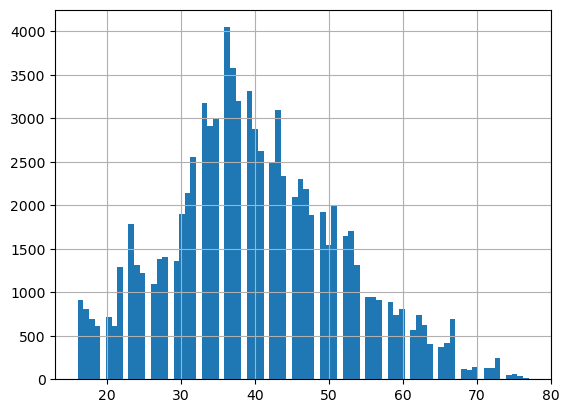

In [1132]:
# распределение возраста клиента

plt.rcParams['axes.grid'] = False
df_1188.age.hist(bins=80);

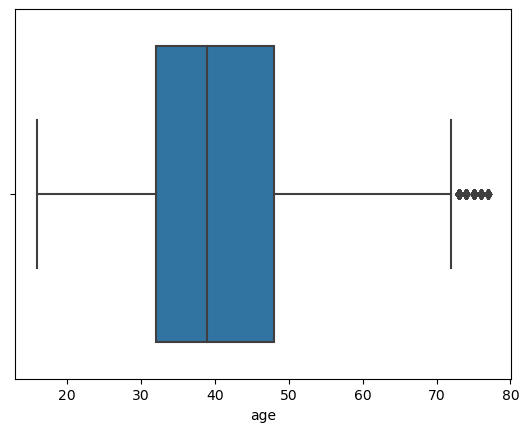

In [1133]:
sns.boxplot(data=df_1188, x='age');

In [1134]:
df_1188.age.quantile(0.05)

22.0

In [1135]:
df_1188.age.quantile(0.75)

48.0

In [1136]:
is_outlier_min = df_1188['age'] < 22
is_outlier_min.sum()

4343

In [1137]:
is_outlier_max = df_1188['age'] > 47
is_outlier_max.sum()

22098

In [1138]:
df_1188.loc[is_outlier_min, 'age'] = int(22)

In [1139]:
df_1188.loc[is_outlier_max, 'age'] = int(48) 

In [1140]:
df_1188.age.describe()

count    87105.000000
mean        38.350451
std          8.464920
min         22.000000
25%         32.000000
50%         39.000000
75%         48.000000
max         48.000000
Name: age, dtype: float64

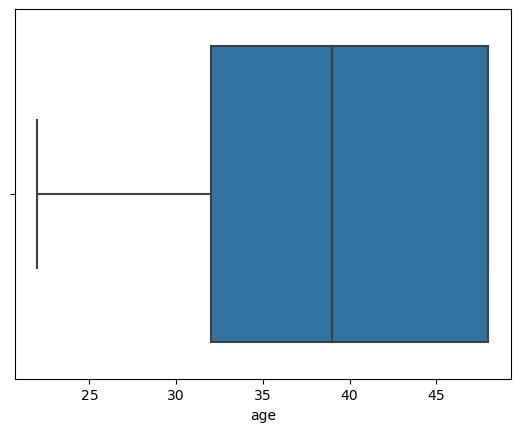

In [1141]:
sns.boxplot(data=df_1188, x='age');

In [1142]:
# выбросы в стоимости (cost)

df_1188.cost.describe()

count     87105.000000
mean       5429.131715
std        9965.992749
min         -30.000000
25%        1499.000000
50%        2999.000000
75%        5609.000000
max      405999.000000
Name: cost, dtype: float64

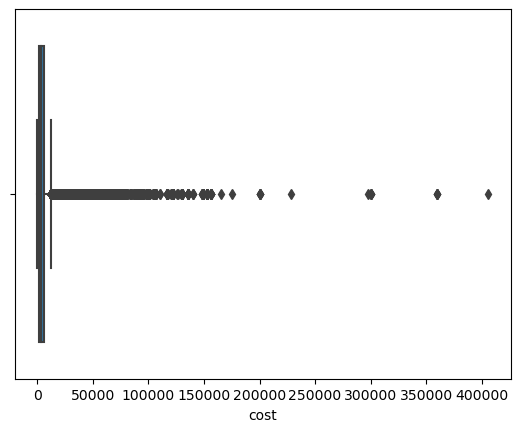

In [1143]:
sns.boxplot(data=df_1188, x='cost');

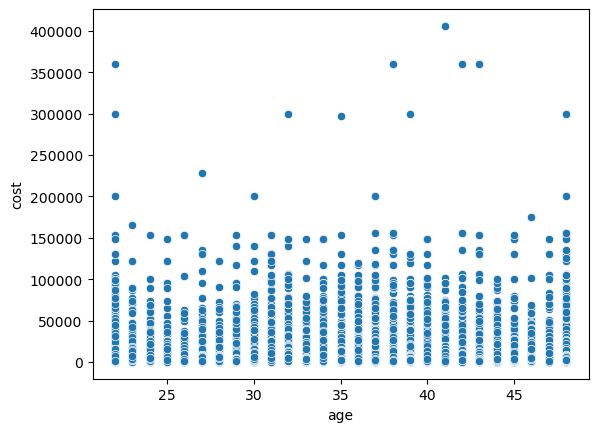

In [1144]:
# попарные зависимости по городу 1188 (возраст и стоимость)

sns.scatterplot(data=df_1188, x='age', y='cost');

In [1145]:
df_1188.cost.describe()

count     87105.000000
mean       5429.131715
std        9965.992749
min         -30.000000
25%        1499.000000
50%        2999.000000
75%        5609.000000
max      405999.000000
Name: cost, dtype: float64

In [1146]:
df_1188.cost.quantile(0.75)

5609.0

In [1147]:
is_outlier_min_cost = df_1188['cost'] < 0
is_outlier_min_cost.sum()

1

In [1148]:
is_outlier_max_cost = df_1188['cost'] > 5609
is_outlier_max_cost.sum()

21771

In [1149]:
df_1188.loc[is_outlier_min_cost, 'cost'] = int(0)

In [1150]:
df_1188.loc[is_outlier_max_cost, 'cost'] = int(5609) # заполним 75 квантилем

In [1151]:
# заполнено min 0, max 75 квантилем

df_1188.cost.describe()

count    87105.000000
mean      3230.690718
std       1879.399372
min          0.000000
25%       1499.000000
50%       2999.000000
75%       5609.000000
max       5609.000000
Name: cost, dtype: float64

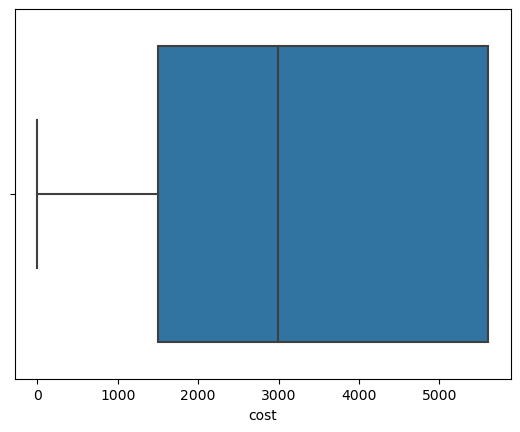

In [1152]:
sns.boxplot(data=df_1188, x='cost');

In [1153]:
df_1188.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87105 entries, 10 to 780116
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        87105 non-null  int64  
 1   personal_coef             87105 non-null  float64
 2   age                       87105 non-null  float64
 3   gender                    87105 non-null  float64
 4   education                 87105 non-null  int64  
 5   product_sex_from_product  87105 non-null  float64
 6   colour_main               87105 non-null  object 
 7   cost                      87105 non-null  int64  
 8   base_sale                 87105 non-null  int64  
 9   dt                        87105 non-null  int64  
 10  short_product             87105 non-null  object 
 11  test_group                87105 non-null  int64  
 12  fact_of_purchase          87105 non-null  int64  
 13  status_of_product         87105 non-null  object 
 14  departmen

#### OneHotEncoder

In [1154]:
df_1188[:2]

,id,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,test_group,fact_of_purchase,status_of_product,department,target
10,6,0.4304,48.0,1.0,0,2.0,мультицвет,4999,0,1,кроссовки,1,1,i_know_what_i_want,shoes,sport_guys
11,6,0.4304,48.0,1.0,0,1.0,черный,4799,1,3,кеды мужские,1,1,i_know_what_i_want,shoes,sport_guys


In [1155]:
df_1188.colour_main.nunique()

124

In [1156]:
df_1188.short_product.nunique()

2066

In [1157]:
df_1188.status_of_product.nunique()

4

In [1158]:
df_1188.department.nunique()

8

In [1159]:
df_ohe = df_1188.copy()

In [1160]:
ohe = OneHotEncoder(sparse_output=False)
ohe

OneHotEncoder(sparse_output=False)

In [1161]:
ohe.fit(df_ohe[['status_of_product', 'department']])

OneHotEncoder(sparse_output=False)

In [1162]:
ohe_columns = ohe.transform(df_ohe[['status_of_product', 'department']])
ohe_columns

array([[0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [1163]:
ohe_columns.shape

(87105, 12)

In [1164]:
df_ohe[ohe.get_feature_names_out()] = ohe_columns

In [1165]:
df_ohe.head()

,id,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,...,status_of_product_magistr_of_sport,status_of_product_real_sportsman,department_camping,department_clothes,department_faster_than_walking,department_other,department_runners,department_shoes,department_take_me_with_you,department_water_equipment
10,6,0.4304,48.0,1.0,0,2.0,мультицвет,4999,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11,6,0.4304,48.0,1.0,0,1.0,черный,4799,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12,6,0.4304,48.0,1.0,0,1.0,синий,999,0,8,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13,6,0.4304,48.0,1.0,0,2.0,синий,1119,1,11,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14,6,0.4304,48.0,1.0,0,2.0,мультицвет,299,0,11,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1166]:
df_ohe = df_ohe.drop(columns=['id', 'status_of_product', 'department'], axis=1)

In [1167]:
df_ohe.head()

,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,...,status_of_product_magistr_of_sport,status_of_product_real_sportsman,department_camping,department_clothes,department_faster_than_walking,department_other,department_runners,department_shoes,department_take_me_with_you,department_water_equipment
10,0.4304,48.0,1.0,0,2.0,мультицвет,4999,0,1,кроссовки,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11,0.4304,48.0,1.0,0,1.0,черный,4799,1,3,кеды мужские,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12,0.4304,48.0,1.0,0,1.0,синий,999,0,8,футболка мужская,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.4304,48.0,1.0,0,2.0,синий,1119,1,11,бейсболка детская,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.4304,48.0,1.0,0,2.0,мультицвет,299,0,11,носки детские,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### LabelEncoder

In [1168]:
# закодируем LabelEncoder категориальный столбец 'short_product'

df_ohe['short_product'] = LabelEncoder().fit_transform(df_ohe['short_product'])

In [1169]:
# закодируем LabelEncoder категориальный столбец 'colour_main'

df_ohe['colour_main'] = LabelEncoder().fit_transform(df_ohe['colour_main'])

In [1170]:
df_ohe[:5]

,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,...,status_of_product_magistr_of_sport,status_of_product_real_sportsman,department_camping,department_clothes,department_faster_than_walking,department_other,department_runners,department_shoes,department_take_me_with_you,department_water_equipment
10,0.4304,48.0,1.0,0,2.0,71,4999,0,1,729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11,0.4304,48.0,1.0,0,1.0,120,4799,1,3,610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12,0.4304,48.0,1.0,0,1.0,102,999,0,8,1858,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.4304,48.0,1.0,0,2.0,102,1119,1,11,121,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14,0.4304,48.0,1.0,0,2.0,71,299,0,11,1119,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Supervised learning

In [1171]:
df_learning = df_ohe.copy()

In [1172]:
df_learning[:3]

,personal_coef,age,gender,education,product_sex_from_product,colour_main,cost,base_sale,dt,short_product,...,status_of_product_magistr_of_sport,status_of_product_real_sportsman,department_camping,department_clothes,department_faster_than_walking,department_other,department_runners,department_shoes,department_take_me_with_you,department_water_equipment
10,0.4304,48.0,1.0,0,2.0,71,4999,0,1,729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
11,0.4304,48.0,1.0,0,1.0,120,4799,1,3,610,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12,0.4304,48.0,1.0,0,1.0,102,999,0,8,1858,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1173]:
x = df_learning.drop(['target'], axis=1)
y = df_learning['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [1174]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60973, 24), (26132, 24), (60973,), (26132,))

In [1175]:
# обучение модели - Логистическая регрессия

logreg_multi_class = LogisticRegression(random_state=42, penalty='l1', solver='saga', max_iter=2000)


In [1176]:
logreg_multi_class.fit(x_train, y_train)

C:\Users\Julia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=2000, penalty='l1', random_state=42, solver='saga')

In [1177]:
logreg_pred_train = logreg_multi_class.predict(x_train)
logreg_pred_test = logreg_multi_class.predict(x_test)

In [1178]:
print(accuracy_score(y_train, logreg_pred_train))
print(accuracy_score(y_test, logreg_pred_test))

0.8936250471520181
0.8884509413745599


In [1181]:
confusion_matrix(y_test, logreg_pred_test)

array([[4314,  357,  164,  745],
       [  96, 9404,  143,  184],
       [ 215,    0, 1950,  551],
       [   0,  398,   62, 7549]], dtype=int64)

In [1182]:
print(classification_report(y_test, logreg_pred_test))

                precision    recall  f1-score   support

athletic_girls       0.93      0.77      0.85      5580
     beginners       0.93      0.96      0.94      9827
     sport_VIP       0.84      0.72      0.77      2716
    sport_guys       0.84      0.94      0.89      8009

      accuracy                           0.89     26132
     macro avg       0.88      0.85      0.86     26132
  weighted avg       0.89      0.89      0.89     26132



In [1183]:
# по дефолту считаются метрики accuracy, метрику можно изменять с пом. параметра scoring=

# Получаем значения метрик на тестовых фолдах, accuracy
# кросс-валидация

cv_score_accuracy_LR = cross_val_score(logreg_multi_class, df_learning.drop("target", axis=1), df_learning.target, cv=4, scoring='accuracy')
cv_score_accuracy_LR

C:\Users\Julia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Julia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Julia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Julia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array([0.89658814, 0.90484938, 0.90540044, 0.8980529 ])

In [1184]:
# среднее и std по accuracy

cv_score_accuracy_LR.mean(), cv_score_accuracy_LR.std()

(0.9012227155108439, 0.003941225237531899)

In [1185]:
# получаем только значения метрик на тестовых фолдах, f1-score (F1-мера)

# average='weighted': При использовании этого параметра метрика вычисляется для каждого класса, 
# затем результаты усредняются с учетом доли каждого класса в тестовом наборе данных.
# это наш случай, целевая переменная не очень сбалансирована

# кросс-валидация

f1_scorer = make_scorer(f1_score, average='weighted')

cv_score_f1_LR = cross_val_score(logreg_multi_class, df_learning.drop("target", axis=1), df_learning.target, cv=4, scoring=f1_scorer)
cv_score_f1_LR


C:\Users\Julia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Julia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Julia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Julia\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array([0.89501753, 0.90367665, 0.90396318, 0.89628322])

In [1189]:
cv_score_f1_LR.mean(), cv_score_f1_LR.std()

(0.8997351459044862, 0.0041104596949590195)

In [1190]:
# метрики не сильно отличаются друг от друга, 
# метрики на обучающем и тестовом наборах данных (и на кросс-валидации) также высоки и близки друг к другу
# значит модель не переобучена

#### Multi class classification (Results)

In [1191]:
# Модель логистической регрессии (многоклассовая классификация) показала среднюю точность предсказания 90%

In [1192]:
# сериализация модели по предсказанию гендера в файл pickle

filename = 'modelgender.pickle'

with open(filename, 'wb') as file:
  pickle.dump(logreg, file)

In [1193]:
# при необходимости можно десериализовать

with open(filename, 'rb') as file:
  model_from_pickle_1 = pickle.load(file)

In [1194]:
model_from_pickle_1

LogisticRegression(C=1, max_iter=1000, random_state=42, solver='liblinear')

In [1195]:
# сериализация модели мультиклассовой классификации в файл pickle

filename = 'model_multi_class.pickle'

with open(filename, 'wb') as file:
  pickle.dump(logreg_multi_class, file)

In [1196]:
# при необходимости можно десериализовать

with open(filename, 'rb') as file:
  model_from_pickle_2 = pickle.load(file)

In [1197]:
model_from_pickle_2

LogisticRegression(max_iter=2000, penalty='l1', random_state=42, solver='saga')

## Results

Успешные Маркетинговые Кампании

Проведенные маркетинговые кампании оказались весьма успешными. Размещение баннерной рекламы на билбордах и предоставление персональной скидки 5 000 клиентам через email-рассылку заметно повысили активность покупателей. Это подтверждается результатами A/B тестирования, кластерного и когортного анализа.

Результаты A/B Теста

A/B тестирование показало, что клиенты, получившие скидку через email-рассылку, значительно увеличили средний чек своих покупок.

Результаты Кластеризации

Кластерный анализ позволил выделить группы клиентов, которые активно участвовали в маркетинговых кампаниях, а также группы, 
для которых можно сформировать индивидуальные предложения.

Когортный Анализ

Когортный анализ, проведенный в период с 1 по 25 день, показал, что основная часть покупок совершается в первый день посещения. По 16 день наблюдается значительный всплеск покупок, что совпадает с периодом проведения первой маркетинговой кампании с 5 по 16 день. После 16 дня активность покупателей стабилизируется на уровне 6%-10% и практически не уменьшается.

Многоклассовая Классификация

Целевая переменная для многоклассовой классификации сегментировала покупателей на группы по ценовой категории товара, гендерной принадлежности и индивидуальным предпочтениям.


Группы покупателей (по результатам многоклассовой классификации):

athletic_girls: женщины со средними затратами на покупки (от 2 до 10 тыс. руб), предпочитающие одежду и обувь

sport_guys: мужчины со средними затратами на покупки (от 2 до 10 тыс. руб), покупающие много одежды и обуви, а также товары для различных видов спорта

beginners: мужчины и женщины, предпочитающие товары с гендерной маркировкой "иное", совершающие небольшие покупки товаров стоимостью менее 2000 рублей или пока не совершившие покупок

sport_VIP: VIP сегмент мужчин и женщин, активно занимающихся различными видами спорта, покупают дорогие товары категории premium и private

Эффективность Сегментации

Сегментация позволяет делать маркетинговые кампании и акции более целенаправленными и ориентированными на конкретные предпочтения покупателей, что повышает их эффективность и удовлетворенность клиентов.
